# Кейс 1. Разработка AI-репетитора по техническим дисциплинам 🎓

Команда **"НейроЭмоции"** (MIFIML)

**Булахов Юрий Эдуардович - ТИМЛИД**

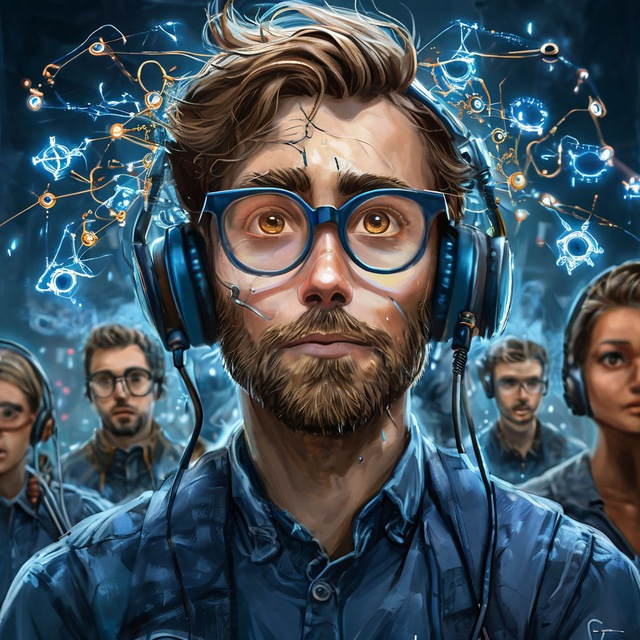

**ЭТАПЫ ПРОЕКТА И ФУНКЦИОНАЛЬНЫЕ РОЛИ УЧАСТНИКОВ КОМАНДЫ:**

***Этап 1: Подготовка и структурирование данных***

**Борзунов Антон Андреевич** - Data & Chunking Engineer

***Этап 2: Векторизация и настройка хранилища***

**Чунарев Дмитрий Дмитриевич** - Vector DB & Embeddings Engineer

***Этап 3: Разработка RAG-ядра и промптов***

**Ситёв Роман Рустамович** - RAG Core & Prompt Engineer

***Этап 4: Бэкенд и API***

**Голунов Артем Сергеевич** - Backend & API Developer

***Этап 5: Пользовательский интерфейс***

**Бикбулатова Айгуль Ришатовна** - UI/UX Core Developer

***Этап 6: Дополнительные функции и оптимизация***

**Булахов Юрий Эдуардович** - Advanced Features & UI Integration Developer

***Этап 7: Интеграция, тестирование и демо***

**Ворошнина Анна Олеговна** - Integration, Testing & Demo Manager

4513679d0f05af1a094823f09591b.svg

**О проекте**

Партнёр — Cloud.ru, российский провайдер облачных сервисов и AI-технологий.
Компания предлагает разработать AI-репетитора по техническим дисциплинам, который помогает студентам осваивать учебный материал, задаёт наводящие вопросы, объясняет сложные темы и предоставляет справочную информацию.

Команды разрабатывают MVP AI-репетитора на основе RAG-подхода, используя предоставленные учебные материалы (учебники, лекции, справочники, лабораторные работы). Проект предполагает реализацию полного пайплайна генерации ответа и создание пользовательского интерфейса для взаимодействия со студентом.

**Целевая аудитория**
- студенты технических направлений;
- люди, осваивающие IT-дисциплины;
- пользователи, которым нужны доступные, понятные и точные инструменты для изучения материалов.

**Основные задачи на хакатоне**
Участникам необходимо разработать MVP AI-репетитора на основе RAG-подхода.

**Требования**
- Собрать корпус учебных материалов (учебники, лекции, справочники).
- Реализовать пайплайн генерации ответов:
   - индексирование,
   - поиск релевантных документов,
   - формирование промпта,
   - выдача развёрнутого ответа.
- Обеспечить точность и прозрачность: ответы должны содержать ссылки на источники и пояснения.
- Создать пользовательский интерфейс (чат-бот или веб-приложение / gradio, streamlit) для взаимодействия со студентом.
- Добавить функции генерации вопросов для самопроверки и рекомендацию дополнительных ресурсов.
- Подготовить презентацию и демо для жюри.

**Дополнительные пожелания/рекомендации**
- Учесть этику:
   - избегать предвзятости,
   - фильтровать нецензурный контент,
   - защищать данные пользователей.
- Предусмотреть масштабируемость:
   - добавлять новые предметы,
   - подключать различные базы знаний,
   - интегрировать голосовые и визуальные возможности.
- Подготовить:
   - описание архитектуры,
   - пошаговую инструкцию по созданию такого AI-репетитора,
   - код,
   - краткую инструкцию по запуску.

**Технические требования**
- Организовать RAG-pipeline, реализовать поиск по эмбеддингам.
- Backend предполагается на Python, код необходимо выложить в репозиторий.
- Обеспечить безопасную работу с данными, логирование и мониторинг.
- UI может быть реализован:
   - на web-фреймворках (gradio, streamlit);
   - через Telegram-бот.

**Референсы**
- Khanmigo (Khan Academy) — AI-ассистент для обучения.
- Evahelp.ai

**Список материалов, предоставляемых заказчиком**

Учебные программы, конспекты лекций и лабораторные задания:
практические руководства Cloud.ru Evolution.

# ***Этап 1: Подготовка и структурирование данных***

**Борзунов Антон Андреевич** - Data & Chunking Engineer

ЗАДАЧИ:
- Анализ структуры сайта Cloud.ru (cloud.ru/docs/tutorials-evolution) и форматов учебных материалов
- Написание скриптов извлечения и очистки руководств Cloud.ru Evolution
- Создание структурированного датасета
- Разбивка на чанки с сохранением метаданных
- Организация выходной структуры

In [ ]:
# Загружаем библиотЭки
import pandas as pd
import os
import re
import json
import time
import csv
import logging
from pathlib import Path
from urllib.parse import urljoin, urlparse
from datetime import datetime
from typing import List, Dict, Any, Optional
import textwrap
import hashlib
from tqdm import tqdm

# Для веб-запросов и парсинга, брал еще Selenium, но он тут не нужен
import requests
from bs4 import BeautifulSoup

# Для работы с колабой
from google.colab import drive

In [ ]:
# Настроим логирование для отслеживания процесса
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('cloud_scraper.log', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [ ]:
# Собираем кастомный JSON ENCODER
class DateTimeEncoder(json.JSONEncoder):
    """
    Умный энкодер для сериализации datetime объектов, работает как швейцарские часы (ну почти)
    """
    def default(self, obj):
        if isinstance(obj, datetime):
            return obj.isoformat()  # превращаем в строку ISO
        if isinstance(obj, Path):
            return str(obj)  # пути тоже в строки
        return super().default(obj)

In [ ]:
# Собираем нашего цифрового экспедитора
class CloudConfig:
    """
    Задает настройки сбора данных
    """
    # Базовые настройки
    BASE_URL = "https://cloud.ru"
    USER_AGENT = "Mozilla/5.0 (compatible; AI-Tutor-Bot/1.0; +hackathon)"
    REQUEST_DELAY = 1.5  # вежливая задержка между запросами
    TIMEOUT = 30
    MAX_RETRIES = 2

    # URL для сбора всех руководств
    CATEGORIES = {
        "all_tutorials": [
            "https://cloud.ru/docs/tutorials-evolution/list/index?source-platform=Evolution",
        ]
    }

    # Настройки пути
    OUTPUT_DIR = "/content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2"

    # Параметры сбора
    MAX_TUTORIALS_PER_PAGE = 1000  # увеличиваем лимит, т.к. руководств много
    MIN_CONTENT_LENGTH = 100  # отсеиваем слишком короткие тексты

    # Параметры для чанкования
    CHUNK_SIZE = 800  # довольно солидный чанк для сохранения контекста
    CHUNK_OVERLAP = 150  # перекрытие между чанками
    MIN_CHUNK_SIZE = 100  # минимальный размер чанка
    MAX_CHUNK_SIZE = 1000  # максимальный размер чанка, можно еще покрутить, но вроде норм

    # Селекторы для поиска контента
    CONTENT_SELECTORS = [
        '.docs-content', '.documentation-content', 'main', '.main-content',
        '#content', '.content', '.article-content', 'article', '.post-content',
        '.tutorial-content', '.guide-content'
    ]

    # Заголовки для HTTP запросов
    HEADERS = {
        'User-Agent': USER_AGENT,
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
        'Referer': 'https://cloud.ru/'
    }

In [ ]:
# Создаем утилиту для разбивки на чанки
class TextChunker:
    """
    Разделяет текст на чанки с сохранением контекста
    ИСПРАВЛЕНО 15.12.2025: Устранена проблема с нарастающими чанками и бесконечным циклом
    """
    @staticmethod
    def split_into_chunks(text: str, chunk_size: int = 800,
                          overlap: int = 150, min_chunk_size: int = 100,
                          max_chunk_size: int = 1000) -> List[Dict[str, Any]]:
        """
        Разбивает текст на перекрывающиеся чанки с сохранением структуры
        """
        chunks = []
        if not text or len(text.strip()) < min_chunk_size:
            return chunks

        # Очищаем текст от лишних пробелов, но сохраняем структуру абзацев
        text = re.sub(r'\n\s*\n', '\n\n', text.strip())
        text = re.sub(r'[ \t]+', ' ', text)

        # Разбиваем на абзацы для сохранения смысловых блоков
        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
        current_chunk = []
        current_length = 0
        chunk_index = 0
        current_start = 0  # точка отсчета для текущего чанка
        i = 0
        while i < len(paragraphs):
            paragraph = paragraphs[i]
            para_length = len(paragraph)

            # Проверяем, является ли параграф кодом или командой
            is_code_block = any(indicator in paragraph.lower() for indicator in
                               ['```', 'sudo', 'apt-get', 'docker', 'kubectl', 'curl', 'ssh', '$', '#'])

            # Если добавление параграфа превышает размер чанка и текущий чанк не пустой
            if current_length + para_length + 1 > chunk_size and current_chunk and not is_code_block:
                # Формируем текущий чанк
                chunk_text = '\n\n'.join(current_chunk)
                # Сохраняем текущий чанк
                chunks.append({
                    'text': chunk_text,
                    'start_char': current_start,
                    'end_char': current_start + len(chunk_text),
                    'chunk_index': chunk_index,
                    'tokens_count': len(chunk_text.split()),
                    'is_continuation': chunk_index > 0
                })

                # Начинаем новый чанк с перекрытием
                chunk_index += 1
                # Определяем сколько абзацев нужно для перекрытия
                overlap_chunks = []
                overlap_length = 0
                # Берем последние абзацы из предыдущего чанка для перекрытия
                for j in range(len(current_chunk)-1, -1, -1):
                    if overlap_length + len(current_chunk[j]) + 1 > overlap:
                        break
                    overlap_chunks.insert(0, current_chunk[j])
                    overlap_length += len(current_chunk[j]) + 1
                # ИСПРАВЛЕНО 15.12.2025: правильный расчет позиции начала следующего чанка
                current_start = current_start + len(chunk_text) - overlap_length
                # Начинаем новый чанк с перекрытия
                current_chunk = overlap_chunks.copy()
                current_length = overlap_length
                # Не увеличиваем i, обрабатываем текущий параграф в новом чанке
                continue

            # Особая обработка для кодовых блоков - храним их целиком
            elif is_code_block:
                # Если текущий чанк не пустой и достаточно большой, сохраняем его
                if current_chunk and current_length > min_chunk_size:
                    chunk_text = '\n\n'.join(current_chunk)
                    chunks.append({
                        'text': chunk_text,
                        'start_char': current_start,
                        'end_char': current_start + len(chunk_text),
                        'chunk_index': chunk_index,
                        'tokens_count': len(chunk_text.split()),
                        'is_continuation': chunk_index > 0
                    })
                    chunk_index += 1
                    current_start += len(chunk_text) + 1
                    current_chunk = []
                    current_length = 0
                # Добавляем кодовый блок как отдельный абзац
                current_chunk.append(paragraph)
                current_length += para_length + 1
                i += 1
                # Не разбиваем кодовые блоки - храним их целиком
            else:
                # Добавляем параграф к текущему чанку
                current_chunk.append(paragraph)
                current_length += para_length + 1
                i += 1
        # Добавляем последний чанк
        if current_chunk:
            chunk_text = '\n\n'.join(current_chunk)
            if len(chunk_text) >= min_chunk_size:
                chunks.append({
                    'text': chunk_text,
                    'start_char': current_start,
                    'end_char': current_start + len(chunk_text),
                    'chunk_index': chunk_index,
                    'tokens_count': len(chunk_text.split()),
                    'is_continuation': chunk_index > 0
                })

        # Пост-обработка: объединяем слишком короткие чанки
        merged_chunks = []
        i = 0
        while i < len(chunks):
            if i < len(chunks) - 1 and len(chunks[i]['text']) < min_chunk_size * 2:
                # Объединяем со следующим чанком
                merged_text = chunks[i]['text'] + "\n\n" + chunks[i+1]['text']
                merged_chunks.append({
                    'text': merged_text,
                    'start_char': chunks[i]['start_char'],
                    'end_char': chunks[i+1]['end_char'],
                    'chunk_index': chunks[i]['chunk_index'],
                    'tokens_count': len(merged_text.split()),
                    'is_continuation': chunks[i]['chunk_index'] > 0,
                    'merged_from': [chunks[i]['chunk_index'], chunks[i+1]['chunk_index']]
                })
                i += 2
            else:
                merged_chunks.append(chunks[i])
                i += 1

        # Восстанавливаем правильную нумерацию чанков
        for i, chunk in enumerate(merged_chunks):
            chunk['chunk_index'] = i
        return merged_chunks

🕷️ Собираем CloudTutorialSpider, который аккуратно плетет паутину из списка материалов, предоставленных заказчиком - практических руководств Cloud.ru Evolution.

Задача - вытащить с сайта https://cloud.ru/docs/tutorials-evolution/list/index учебные материалы.

In [ ]:
# Создаем основной класс - вежливого паука для сбора учебных материалов
class CloudTutorialSpider:
    """
    Вежливый паук для сбора учебных материалов: не ломает сайты, не спамит, собирает только нужное - практические руководства Cloud.ru Evolution
    """
    def __init__(self, config=None):
        self.config = config or CloudConfig()
        self.session = requests.Session()
        self.session.headers.update(self.config.HEADERS)

        # Статистика
        self.stats = {
            "start_time": None,
            "end_time": None,
            "total_pages_processed": 0,
            "total_tutorials_found": 0,
            "total_tutorials_saved": 0,
            "total_chunks_created": 0,
            "failed_urls": [],
            "categories": {},
            "total_chars": 0,
            "total_chunks": 0,
            "total_tables": 0
        }

        # Хранилище данных
        self.tutorials = []
        self.chunks = []

        # Создаем директории
        self._setup_directories()
        print(f"\nCloudTutorialSpider инициализирован на базе: {self.config.BASE_URL}.")
        print(f"Результаты будут в: {self.config.OUTPUT_DIR}.")
        print(f"Категории для сбора: {list(self.config.CATEGORIES.keys())}.")

    def _setup_directories(self):
        """
        Создает аккуратную структуру папок
        """
        # Проверяем и создаем основную папку OUTPUT_DIR
        if not os.path.exists(self.config.OUTPUT_DIR):
            print(f"Создаем основную папку: {self.config.OUTPUT_DIR}")
            os.makedirs(self.config.OUTPUT_DIR, exist_ok=True)
        else:
            print(f"Основная папка уже существует: {self.config.OUTPUT_DIR}.")

        # Папка с делением на категории
        os.makedirs(os.path.join(self.config.OUTPUT_DIR, "categories"), exist_ok=True)

        # Папки для форматов
        formats = ["json", "csv", "logs", "chunks", "rag_ready"]
        for fmt in formats:
            os.makedirs(os.path.join(self.config.OUTPUT_DIR, fmt), exist_ok=True)
        print("Структура папок создана.")

    def _make_request(self, url: str) -> Optional[str]:
        """
        HTTP запрос с обработкой ошибок. Возвращает HTML или None
        """
        # Задержка для вежливости
        time.sleep(self.config.REQUEST_DELAY)
        for attempt in range(self.config.MAX_RETRIES):
            try:
                print(f"Запрос к {url} (попытка {attempt + 1}).")
                response = self.session.get(
                    url,
                    timeout=self.config.TIMEOUT,
                    allow_redirects=True
                )

                # Анализируем ответ
                if response.status_code == 200:
                    # Проверяем кодировку
                    if response.encoding != 'utf-8':
                        response.encoding = 'utf-8'
                    # Проверяем, что это не страница с ошибкой
                    text_lower = response.text.lower()
                    if any(phrase in text_lower for phrase in
                          ["страница не найдена", "error 404", "404 not found", "ошибка 404"]):
                        print(f"Страница 200, но говорит 'не найдена': {url}")
                        return None
                    print(f"Успешный ответ от {url}.")
                    return response.text
                elif response.status_code == 404:
                    print(f"Страница не найдена (404): {url}.")
                    self.stats["failed_urls"].append({"url": url, "reason": "404"})
                    return None
                elif response.status_code == 403:
                    print(f"Доступ запрещен (403): {url}")
                    return None
                else:
                    print(f"Неожиданный код {response.status_code}: {url}")
                    if attempt < self.config.MAX_RETRIES - 1:
                        wait_time = 3 * (attempt + 1)
                        print(f"Ждем {wait_time} сек перед повтором.")
                        time.sleep(wait_time)
                        continue
            except requests.exceptions.Timeout:
                print(f"Таймаут при запросе: {url}.")
                if attempt < self.config.MAX_RETRIES - 1:
                    time.sleep(5)
                    continue
            except Exception as e:
                print(f"Ошибка запроса: {str(e)[:50]}.")
                break

        # Если все попытки исчерпаны
        self.stats["failed_urls"].append({"url": url, "reason": "max_retries"})
        return None

    def _extract_tutorial_links_from_list(self, html: str, base_url: str,
                                         current_depth: int = 0) -> List[Dict[str, str]]:
        """
        Извлекает ссылки на руководства со страницы списка с ограничением глубины
        """
        # Добавим простое ограничение глубины, чтобы не улететь в кроличью нору
        MAX_DEPTH = 10
        if current_depth >= MAX_DEPTH:
            print(f"Максимальная глубина пагинации ({MAX_DEPTH}) достигнута.")
            return []
        soup = BeautifulSoup(html, 'html.parser')
        links = []
        # Ищем все ссылки на странице
        all_links = soup.find_all('a', href=True)
        for link in all_links:
            href = link.get('href')
            title = link.get_text(strip=True)
            # Пропускаем короткие или неинформативные заголовки
            if not title or len(title) < 5 or len(title) > 200:
                continue
            # Проверяем, что это ссылка на руководство
            if not href:
                continue
            # Делаем URL абсолютным
            full_url = urljoin(base_url, href)
            # Фильтруем только руководства (должны содержать 'tutorials-evolution/list/topics/')
            if 'tutorials-evolution/list/topics/' not in full_url:
                continue
            # Определяем категорию по URL или заголовку
            category = self._detect_category(full_url, title)
            links.append({
                'url': full_url,
                'title': title[:200],
                'category': category,
                'found_by': 'url_pattern'
            })
        # Обрабатываем пагинации
        next_page_url = None
        # Ищем ссылки на следующую страницу
        pagination_selectors = [
            '.pagination', '.page-nav', '.next-page', 'a[rel="next"]'
        ]
        for selector in pagination_selectors:
            next_elements = soup.select(selector)
            for element in next_elements:
                if element.name == 'a' and element.get('href'):
                    next_page_url = urljoin(base_url, element.get('href'))
                    print(f"Найдена пагинация: следующая страница - {next_page_url}.")
                    break
            if next_page_url:
                break
        # Также ищем по тексту ссылок
        if not next_page_url:
            # Ищем ссылки с текстом "Далее", "Next" или ">"
            for link in soup.find_all('a'):
                link_text = link.get_text(strip=True).lower()
                if link.get('href') and link_text in ['далее', 'next', '>', '»']:
                    next_page_url = urljoin(base_url, link.get('href'))
                    print(f"Найдена пагинация по тексту: следующая страница - {next_page_url}.")
                    break
        # Рекурсивно обрабатываем следующую страницу, чтобы была связка
        if next_page_url:
            try:
                print(f"Загружаем следующую страницу пагинации: {next_page_url}.")
                next_html = self._make_request(next_page_url)
                if next_html:
                    next_links = self._extract_tutorial_links_from_list(next_html, next_page_url, current_depth + 1)
                    links.extend(next_links)
            except Exception as e:
                print(f"Ошибка при обработке пагинации: {e}.")
        # Удаляем дубликаты по URL
        seen_urls = set()
        unique_links = []
        for link in links:
            if link['url'] not in seen_urls:
                seen_urls.add(link['url'])
                unique_links.append(link)
        # Сортируем по категории и заголовку
        unique_links.sort(key=lambda x: (x['category'], x['title']))
        return unique_links[:self.config.MAX_TUTORIALS_PER_PAGE]

    def _detect_category(self, url: str, title: str) -> str:
        """
        Определяет категорию руководства по URL и заголовку
        """
        url_lower = url.lower()
        title_lower = title.lower()

        # Определение по URL на всякий пожарный
        if 'notebooks' in url_lower:
            return "Notebooks"
        elif 'virtual-machines' in url_lower or 'vm' in url_lower or 'виртуальн' in title_lower:
            return "Инфраструктура"
        elif 'vpc' in url_lower or 'network' in url_lower or 'сеть' in title_lower:
            return "Сеть"
        elif 'object-storage' in url_lower or 'хранилищ' in title_lower:
            return "Хранение данных"
        elif 'kubernetes' in url_lower or 'container' in url_lower or 'контейнер' in title_lower:
            return "Контейнеры"
        elif 'kafka' in url_lower:
            return "Брокеры сообщений"
        elif 'postgresql' in url_lower or 'redis' in url_lower or 'баз' in title_lower:
            return "Базы данных"
        elif 'ai' in url_lower or 'ml' in url_lower or 'искусс' in title_lower:
            return "AI Factory"
        elif 'monitoring' in url_lower or 'логирован' in title_lower:
            return "Мониторинг"
        elif 'terraform' in url_lower or 'ci/cd' in title_lower:
            return "DevOps"
        elif 'битрикс' in title_lower or 'wordpress' in title_lower:
            return "Веб-приложения"
        else:
            # Определение по ключевым словам в заголовке, чтобы уж наверняка
            if any(word in title_lower for word in ['docker', 'контейнер', 'k8s', 'pod', 'deployment']):
                return "Контейнеры"
            elif any(word in title_lower for word in ['баз', 'postgres', 'mysql', 'redis', 'mongodb']):
                return "Базы данных"
            elif any(word in title_lower for word in ['виртуальн', 'сервер', 'vm', 'инфраструктур']):
                return "Инфраструктура"
            elif any(word in title_lower for word in ['нейросет', 'ai', 'ml', 'обучен', 'модел']):
                return "AI Factory"
            elif any(word in title_lower for word in ['сеть', 'vpn', 'ip', 'маршрутизац']):
                return "Сеть"
            else:
                return "Общее"

    def _table_to_text(self, table) -> str:
        """
        Преобразует таблицу HTML в текстовый формат
        """
        rows = []
        for tr in table.find_all('tr'):
            cells = []
            for td in tr.find_all(['td', 'th']):
                cells.append(td.get_text(strip=True))
            if cells:
                rows.append(' | '.join(cells))
        return '\n'.join(rows)

    def _extract_content(self, html: str, url: str) -> Dict[str, Any]:
        """
        Извлекает чистый контент со страницы руководства, сохраняет код и технические детали, обрабатывает таблицы
        """
        soup = BeautifulSoup(html, 'html.parser')

        # Удаляем ненужные элементы, но сохраняем важные технические детали
        garbage_selectors = [
            'header', 'footer', 'nav', 'aside',
            '.sidebar', '.menu', '.navigation',
            '.ads', '.advertisement', '.comments',
            '.share-buttons', '.social-share',
            '.breadcrumbs', '.pagination',
            'script', 'style', 'iframe',
            '.feedback', '.rating', '.metadata',
            '.toc', '.table-of-contents'
        ]
        for selector in garbage_selectors:
            for element in soup.select(selector):
                element.decompose()

        # Ищем основной контент
        content_element = None
        for selector in self.config.CONTENT_SELECTORS:
            elements = soup.select(selector)
            if elements:
                content_element = elements[0]
                break

        # Если не нашли, используем боди
        if not content_element:
            content_element = soup.find('body')

        # Извлекаем заголовок
        title = "Без названия"
        title_selectors = ['h1', '.page-title', '.article-title', 'title', 'h2']
        for selector in title_selectors:
            if content_element:
                title_elem = content_element.find(selector)
            else:
                title_elem = soup.find(selector)
            if title_elem and title_elem.get_text(strip=True):
                title = title_elem.get_text(strip=True)
                break

        # Извлекаем таблицы
        tables = []
        if content_element:
            table_elements = content_element.find_all('table')
            for table in table_elements:
                table_text = self._table_to_text(table)
                if table_text and len(table_text.strip()) > 10:
                    tables.append(table_text)

        # Извлекаем блоки кода ДО очистки текста
        code_blocks = []
        if content_element:
            # Сохраняем оригинальные кодовые блоки перед их удалением из основного контента
            code_elements = content_element.find_all(['pre', 'code'])
            for code_elem in code_elements:
                code_text = code_elem.get_text(strip=False)
                if code_text and len(code_text.strip()) > 10:  # пропускаем очень короткие
                    # Определяем язык кода
                    language = "unknown"
                    if code_elem.get('class'):
                        for cls in code_elem.get('class'):
                            if 'language-' in cls:
                                language = cls.replace('language-', '')
                                break
                    code_blocks.append({
                        'text': code_text,
                        'language': language,
                        'length': len(code_text),
                        'html': str(code_elem)  # сохраняем оригинальный HTML для точности
                    })

        # Создаем отдельные текстовые представления кода для вставки в основной контент
        code_placeholders = {}
        for i, block in enumerate(code_blocks):
            placeholder = f"[[CODE_BLOCK_{i}]]"
            code_preview = f"```{block['language']}\n{block['text'].strip()[:50]}...\n```"
            code_placeholders[placeholder] = {
                'full_code': block['text'],
                'language': block['language'],
                'preview': code_preview
            }

        # Заменяем HTML-элементы кода на плейсхолдеры НАПРЯМУЮ в DOM
        if content_element:
            for i, code_elem in enumerate(content_element.find_all(['pre', 'code'])):
                placeholder = f"[[CODE_BLOCK_{i}]]"
                code_elem.replace_with(placeholder)

        # Извлекаем весь текст, включая технические детали, но без дублирующего кода
        all_text = ""
        if content_element:
            # Получаем весь текст, сохраняя структуру
            all_text = content_element.get_text(separator='\n', strip=True)

        # Очищаем текст от технических фраз, но сохраняем инструкции
        lines = []
        for line in all_text.split('\n'):
            line = line.strip()
            if not line:
                continue
            # Пропускаем мусор - технические и навигационные фразы
            skip_phrases = [
                'эта статья полезна?', 'была ли эта статья полезной?',
                'оцените статью', 'поделиться', 'содержание',
                'назад', 'вперед', 'читать также', 'рекомендуем',
                '©', 'copyright', 'все права защищены',
                'быстрое создание обращений', 'следующая статья', 'предыдущая статья'
            ]
            if any(phrase in line.lower() for phrase in skip_phrases):
                continue

            # Обрабатываем строки с кодом - сохраняем их целиком
            is_code_line = any(cmd in line.lower() for cmd in ['$', '#', 'sudo ', 'apt-', 'yum ', 'docker ', 'kubectl ', 'git ', 'ssh ', 'curl ', 'wget ', 'ping ', 'ip ', 'ls ', 'cd ', 'mkdir ', 'rm ', 'cp ', 'mv '])
            if is_code_line:
                # Сохраняем полные команды, даже если они короткие
                lines.append(line)
                continue
            if len(line) > 5:  # отсеиваем очень короткие строки
                lines.append(line)

        # Объединяем строки в текст
        cleaned_text = '\n'.join(lines)

        # НЕ заменяем плейсхолдеры на полный код в основном тексте, это решает проблему дублирования кода

        # Добавляем таблицы в основной текст
        if tables:
            cleaned_text += "\n" + "="*50 + "\nТАБЛИЦЫ:\n" + "="*50 + "\n"
            for i, table in enumerate(tables, 1):
                cleaned_text += f"Таблица {i}:\n{table}\n"

        # Создаем метаданные
        metadata = {
            'url': url,
            'title': title,
            'chars_count': len(cleaned_text),
            'lines_count': len(lines),
            'code_blocks_count': len(code_blocks),
            'tables_count': len(tables),
            'scraped_at': datetime.now(),
            'domain': urlparse(url).netloc,
            'has_code': len(code_blocks) > 0,
            'has_tables': len(tables) > 0,
            'source_hash': hashlib.md5(url.encode()).hexdigest()[:16],
            'original_code_blocks': len(code_blocks)  # для отладки
        }

        return {
            'title': title,
            'content': cleaned_text,
            'code_blocks': code_blocks,
            'tables': tables,
            'metadata': metadata
        }

    def _create_chunks_from_tutorial(self, tutorial: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Создает чанки из руководства с сохранением контекста
        ИСПРАВЛЕНО 16.12.2025: Устранена проблема с дублированием кода
        """
        chunks = []
        doc_id = tutorial['metadata'].get('doc_id', 'unknown')

        # Разбиваем текст на абзацы для точной обработки
        paragraphs = [p.strip() for p in tutorial['content'].split('\n') if p.strip()]

        # Создаем чанки из основного контента
        text_chunks = TextChunker.split_into_chunks(
            tutorial['content'],
            chunk_size=self.config.CHUNK_SIZE,
            overlap=self.config.CHUNK_OVERLAP,
            min_chunk_size=self.config.MIN_CHUNK_SIZE,
            max_chunk_size=self.config.MAX_CHUNK_SIZE
        )

        # Создаем отдельные чанки для блоков кода (только если они есть)
        code_blocks = tutorial.get('code_blocks', [])

        # Рассчитываем общее количество чанков для всего документа
        total_text_chunks = len(text_chunks)
        total_code_chunks = (len(code_blocks) + 1) // 2  # группируем по 1-2 блока
        total_chunks_for_document = total_text_chunks + total_code_chunks

        print(f"Создание чанков для документа {doc_id}: текстовых={total_text_chunks}, код={total_code_chunks}, всего={total_chunks_for_document}.")

        # Добавляем метаданные к каждому текстовому чанку
        for chunk_data in text_chunks:
            chunk_id = f"{tutorial['metadata']['source_hash']}_{chunk_data['chunk_index']:04d}"
            # Проверяем, нет ли дубликатов ID
            existing_ids = [c['id'] for c in chunks if c['id'] == chunk_id]
            if existing_ids:
                chunk_id = f"{chunk_id}_dup{len(existing_ids)}"

            # Проверяем наличие плейсхолдеров кода в чанке
            has_code_references = any(f"[[CODE_BLOCK_" in chunk_data['text'] for _ in range(len(code_blocks)))

            # Точная проверка наличия кодовых команд (без ложных срабатываний)
            has_code_here = False
            lines = chunk_data['text'].split('\n')
            for line in lines:
                line_lower = line.lower().strip()
                # Проверяем начало строки на команды
                if any(line_lower.startswith(cmd) for cmd in ['$ ', '# ', 'sudo ', 'docker ', 'kubectl ', 'git ', 'ssh ', 'curl ', 'wget ', 'apt-', 'yum ']):
                    has_code_here = True
                    break
                # Проверяем полные команды внутри текста
                if any(f' {cmd}' in line_lower for cmd in ['sudo ', 'docker ', 'kubectl ', 'git ', 'ssh ', 'curl ', 'wget ', 'apt-get ', 'apt install ']):
                    has_code_here = True
                    break

            chunk = {
                'id': chunk_id,
                'text': chunk_data['text'],
                'metadata': {
                    'source_title': tutorial['title'],
                    'source_url': tutorial['metadata']['url'],
                    'category': tutorial['metadata'].get('category', 'unknown'),
                    'chunk_id': chunk_data['chunk_index'],
                    'total_chunks': total_chunks_for_document,
                    'source_hash': tutorial['metadata']['source_hash'],
                    'doc_id': doc_id,
                    'has_code': has_code_here or has_code_references,  # ТОЧНО определяем наличие кода в этом чанке
                    'has_tables': tutorial['metadata'].get('has_tables', False),
                    'tokens_count': chunk_data['tokens_count'],
                    'chunk_type': 'text',
                    'chunk_index': chunk_data['chunk_index'],
                    'is_code_related': has_code_references,
                    'contains_code_placeholders': has_code_references
                }
            }
            chunks.append(chunk)

        # Создаем чанки для блоков кода ТОЛЬКО если они есть
        if code_blocks:
            # Группируем код по 1-2 блока на чанк
            for i in range(0, len(code_blocks), 2):
                block_group = code_blocks[i:min(i+2, len(code_blocks))]
                code_texts = []
                for block in block_group:
                    # Добавляем контекст для кода
                    code_texts.append(f"```{block.get('language', '')}\n{block['text'].strip()}\n```")

                # Создаем уникальные идентификаторы для чанков с кодом
                code_chunk_index = total_text_chunks + (i // 2)
                chunk_id = f"{tutorial['metadata']['source_hash']}_code_{i//2:04d}"
                # Проверяем дубликаты
                existing_ids = [c['id'] for c in chunks if c['id'] == chunk_id]
                if existing_ids:
                    chunk_id = f"{chunk_id}_dup{len(existing_ids)}"

                # Ищем контекстные текстовые чанки
                context_chunks = []
                for j, chunk in enumerate(text_chunks):
                    if j >= len(text_chunks) - 2:  # последние 2 чанка как контекст
                        chunk_preview = chunk['text'].lower()
                        context_chunks.append(chunk['text'][:200] + '...' if len(chunk['text']) > 200 else chunk['text'])

                # Формируем контекст для кодового чанка
                context_text = "\n".join(context_chunks[-2:]) if context_chunks else ""

                chunk = {
                    'id': chunk_id,
                    'text': f"КОНТЕКСТ ИСПОЛЬЗОВАНИЯ:\n{context_text}\n\nПРИМЕРЫ КОДА И КОМАНД:\n" + "\n".join(code_texts),
                    'metadata': {
                        'source_title': f"{tutorial['title']} (код)",
                        'source_url': tutorial['metadata']['url'],
                        'category': tutorial['metadata'].get('category', 'unknown'),
                        'chunk_id': code_chunk_index,  # продолжаем нумерацию после текстовых
                        'total_chunks': total_chunks_for_document,
                        'source_hash': tutorial['metadata']['source_hash'],
                        'doc_id': doc_id,
                        'has_code': True,
                        'is_code_block': True,
                        'is_complete_code': True,  # Явно указываем, что это полный код
                        'code_language': ', '.join([block.get('language', 'unknown') for block in block_group]),
                        'tokens_count': sum(len(text.split()) for text in code_texts),
                        'chunk_type': 'code',
                        'original_code_count': len(block_group),
                        'context_from_text_chunks': context_chunks,
                        'is_code_intact': True  # Гарантируем целостность кода
                    }
                }
                chunks.append(chunk)

        return chunks

    def scrape_category(self, category_name: str, urls: List[str]) -> List[Dict[str, Any]]:
        """
        Собирает все руководства из одной категории
        """
        print(f"\nКАТЕГОРИЯ: {category_name.upper()}")
        category_tutorials = []
        for url in urls:
            print(f"Обрабатываю URL: {url[:80]}...")
            self.stats["total_pages_processed"] += 1
            # Загружаем страницу
            html = self._make_request(url)
            if not html:
                print(f"Не удалось загрузить страницу.")
                continue
            # Ищем ссылки на руководства
            tutorial_links = self._extract_tutorial_links_from_list(html, url)
            if not tutorial_links:
                print(f"Ссылок на руководства не найдено. Пробуем обработать как самостоятельное руководство.")
                # Пробуем обработать как самостоятельное руководство
                content_data = self._extract_content(html, url)
                if content_data['metadata']['chars_count'] >= self.config.MIN_CONTENT_LENGTH:
                    content_data['metadata']['category'] = category_name
                    content_data['metadata']['source_type'] = 'direct_page'
                    content_data['metadata']['doc_id'] = f"doc_{len(category_tutorials):04d}"
                    category_tutorials.append(content_data)
                    self.stats["total_tutorials_saved"] += 1
                    self.stats["total_tables"] += content_data['metadata'].get('tables_count', 0)
                    print(f"Сохранено как руководство.")
                continue
            print(f"Найдено ссылок на руководства: {len(tutorial_links)}")
            self.stats["total_tutorials_found"] += len(tutorial_links)
            for link in tqdm(tutorial_links, desc=f"Сбор руководств {category_name}", leave=True):
                # Загружаем руководство
                tutorial_html = self._make_request(link['url'])
                if not tutorial_html:
                    continue
                # Извлекаем контент
                content_data = self._extract_content(tutorial_html, link['url'])
                # Проверяем, что контент не слишком короткий
                if content_data['metadata']['chars_count'] < self.config.MIN_CONTENT_LENGTH:
                    continue
                # Добавляем категорию и другие метаданные
                content_data['metadata']['category'] = link.get('category', category_name)
                content_data['metadata']['source_url'] = url
                content_data['metadata']['doc_id'] = f"doc_{len(category_tutorials):04d}"
                # Сохраняем
                category_tutorials.append(content_data)
                self.stats["total_tutorials_saved"] += 1
                self.stats["total_chars"] += content_data['metadata']['chars_count']
                self.stats["total_tables"] += content_data['metadata'].get('tables_count', 0)
                # Создаем чанки
                tutorial_chunks = self._create_chunks_from_tutorial(content_data)
                self.chunks.extend(tutorial_chunks)
                self.stats["total_chunks"] += len(tutorial_chunks)
                # Вежливая пауза
                time.sleep(0.3)
        # Сохраняем статистику по категории
        self.stats["categories"][category_name] = len(category_tutorials)
        # Сохраняем промежуточные результаты
        if category_tutorials:
            self._save_category_results(category_name, category_tutorials)
        return category_tutorials

    def _save_category_results(self, category_name: str, tutorials: List[Dict[str, Any]]):
        """
        Сохраняет результаты по категории в разных форматах
        """
        category_dir = os.path.join(self.config.OUTPUT_DIR, "categories")

        # 1. JSON
        json_path = os.path.join(category_dir, f"{category_name}.json")
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(tutorials, f, ensure_ascii=False, indent=2, cls=DateTimeEncoder)

        # 2. CSV для удобного просмотра
        csv_path = os.path.join(category_dir, f"{category_name}.csv")
        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['№', 'Заголовок', 'URL', 'Символов', 'Строк', 'Дата сбора', 'Категория', 'Блоков кода', 'Таблиц'])
            for i, tutorial in enumerate(tutorials, 1):
                writer.writerow([
                    i,
                    tutorial['title'][:80],
                    tutorial['metadata']['url'],
                    tutorial['metadata']['chars_count'],
                    tutorial['metadata']['lines_count'],
                    tutorial['metadata']['scraped_at'].isoformat()[:19],
                    tutorial['metadata'].get('category', 'unknown'),
                    tutorial['metadata'].get('code_blocks_count', 0),
                    tutorial['metadata'].get('tables_count', 0)
                ])
        print(f"Категория сохранена: {len(tutorials)} руководств.")
        print(f"  JSON: {json_path}")
        print(f"  CSV: {csv_path}")

    def scrape_all(self) -> List[Dict[str, Any]]:
        """
        Главный метод: собирает все по всем категориям
        """
        print("\nЗапуск сбора данных с сайта CLOUD.RU. Полетели!")
        self.stats["start_time"] = datetime.now()
        all_tutorials = []
        # Монтируем Google Drive
        try:
            drive.mount('/content/drive', force_remount=True)
            print("Google Drive подключен.")
        except Exception as e:
            print(f"Ошибка подключения Google Drive: {e}.")
        # Собираем по категориям
        for category_name, urls in self.config.CATEGORIES.items():
            print(f"\nКатегория {category_name}: {len(urls)} URL для обработки.")
            tutorials = self.scrape_category(category_name, urls)
            all_tutorials.extend(tutorials)
            print(f"Собрано: {len(tutorials)} руководств.")
        # Сохраняем все результаты
        self.tutorials = all_tutorials
        self.stats["end_time"] = datetime.now()
        self._save_all_results()
        self._print_final_report()
        return all_tutorials

    def _save_all_results(self):
        """
        Сохраняет все собранные данные в разных форматах
        """
        # Подготовка данных
        output_data = {
            'metadata': {
                'project': 'AI-репетитор Cloud.ru от NeuroEmotions',
                'version': '1.6',
                'scraped_at': datetime.now(),
                'stats': self.stats,
                'chunking_config': {
                    'chunk_size': self.config.CHUNK_SIZE,
                    'chunk_overlap': self.config.CHUNK_OVERLAP,
                    'min_chunk_size': self.config.MIN_CHUNK_SIZE,
                    'max_chunk_size': self.config.MAX_CHUNK_SIZE
                }
            },
            'config': {
                'categories': list(self.config.CATEGORIES.keys()),
                'total_urls': sum(len(urls) for urls in self.config.CATEGORIES.values()),
                'output_dir': self.config.OUTPUT_DIR
            },
            'tutorials': self.tutorials
        }
        # 1. Полный JSON дамп
        json_path = os.path.join(self.config.OUTPUT_DIR, "json", "NeuroEmotions_all_tutorials_1.6.json")
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(output_data, f, ensure_ascii=False, indent=2, cls=DateTimeEncoder)

        # 2. Упрощенный JSON
        simple_path = os.path.join(self.config.OUTPUT_DIR, "json", "NeuroEmotions_tutorials_simple_1.6.json")
        simple_data = []
        for tutorial in self.tutorials:
            simple_data.append({
                'text': tutorial['content'],
                'title': tutorial['title'],
                'category': tutorial['metadata'].get('category', 'unknown'),
                'url': tutorial['metadata']['url'],
                'chars': tutorial['metadata']['chars_count'],
                'has_code': tutorial['metadata'].get('has_code', False),
                'has_tables': tutorial['metadata'].get('has_tables', False),
                'code_blocks': tutorial.get('code_blocks', []),
                'tables': tutorial.get('tables', []),
                'doc_id': tutorial['metadata'].get('doc_id', 'unknown'),
                'source_hash': tutorial['metadata'].get('source_hash', '')
            })
        with open(simple_path, 'w', encoding='utf-8') as f:
            json.dump(simple_data, f, ensure_ascii=False, indent=2)

        # 3. JSON с чанками в формате для RAG
        chunks_path = os.path.join(self.config.OUTPUT_DIR, "chunks", "NeuroEmotions_all_chunks_1.6.json")
        chunks_data = {
            'metadata': {
                'total_chunks': len(self.chunks),
                'total_documents': len(self.tutorials),
                'chunk_size': self.config.CHUNK_SIZE,
                'chunk_overlap': self.config.CHUNK_OVERLAP,
                'created_at': datetime.now().isoformat()
            },
            'chunks': self.chunks
        }
        with open(chunks_path, 'w', encoding='utf-8') as f:
            json.dump(chunks_data, f, ensure_ascii=False, indent=2, cls=DateTimeEncoder)

        # 4. JSON в формате для RAG
        rag_path = os.path.join(self.config.OUTPUT_DIR, "rag_ready", "NeuroEmotions_all_chunks_for_rag_1.6.json")
        rag_chunks = []
        for chunk in self.chunks:
            rag_chunks.append({
                'id': chunk['id'],
                'text': chunk['text'],
                'metadata': chunk['metadata']
            })
        with open(rag_path, 'w', encoding='utf-8') as f:
            json.dump(rag_chunks, f, ensure_ascii=False, indent=2, cls=DateTimeEncoder)

        # 5. CSV для анализа
        csv_path = os.path.join(self.config.OUTPUT_DIR, "csv", "NeuroEmotions_all_tutorials_1.6.csv")
        df_data = []
        for tutorial in self.tutorials:
            df_data.append({
                'category': tutorial['metadata'].get('category', 'unknown'),
                'title': tutorial['title'],
                'url': tutorial['metadata']['url'],
                'chars': tutorial['metadata']['chars_count'],
                'lines': tutorial['metadata']['lines_count'],
                'code_blocks': tutorial['metadata'].get('code_blocks_count', 0),
                'tables': tutorial['metadata'].get('tables_count', 0),
                'has_code': tutorial['metadata'].get('has_code', False),
                'has_tables': tutorial['metadata'].get('has_tables', False),
                'scraped_at': tutorial['metadata']['scraped_at'],
                'doc_id': tutorial['metadata'].get('doc_id', ''),
                'content_preview': tutorial['content'][:200] + '...' if len(tutorial['content']) > 200 else tutorial['content']
            })
        df = pd.DataFrame(df_data)
        df.to_csv(csv_path, index=False, encoding='utf-8')

        # 6. CSV с чанками
        chunks_csv_path = os.path.join(self.config.OUTPUT_DIR, "csv", "NeuroEmotions_all_chunks_1.6.csv")
        chunks_df_data = []
        for chunk in self.chunks:
            chunks_df_data.append({
                'chunk_id': chunk['id'],
                'doc_id': chunk['metadata'].get('doc_id', 'unknown'),
                'title': chunk['metadata'].get('source_title', ''),
                'category': chunk['metadata'].get('category', 'unknown'),
                'chunk_index': chunk['metadata'].get('chunk_id', 0),
                'total_chunks': chunk['metadata'].get('total_chunks', 0),
                'tokens_count': chunk['metadata'].get('tokens_count', 0),
                'has_code': chunk['metadata'].get('has_code', False),
                'has_tables': chunk['metadata'].get('has_tables', False),
                'is_code_block': chunk['metadata'].get('is_code_block', False),
                'chunk_type': chunk['metadata'].get('chunk_type', 'unknown'),
                'is_complete_code': chunk['metadata'].get('is_complete_code', False),
                'url': chunk['metadata'].get('source_url', ''),
                'source_hash': chunk['metadata'].get('source_hash', ''),
                'chunk_preview': chunk['text'][:150] + '...' if len(chunk['text']) > 150 else chunk['text']
            })
        chunks_df = pd.DataFrame(chunks_df_data)
        chunks_df.to_csv(chunks_csv_path, index=False, encoding='utf-8')

        # 7. Статистика
        stats_path = os.path.join(self.config.OUTPUT_DIR, "logs", "NeuroEmotions_stats.json")
        with open(stats_path, 'w', encoding='utf-8') as f:
            json.dump(self.stats, f, ensure_ascii=False, indent=2, cls=DateTimeEncoder)
        print("\nВсе результаты сохранены:")
        print(f"Полный дамп: {json_path}")
        print(f"Упрощенный JSON: {simple_path}")
        print(f"JSON с чанками: {chunks_path}")
        print(f"RAG-ready JSON: {rag_path}")
        print(f"CSV таблица: {csv_path}")
        print(f"CSV с чанками: {chunks_csv_path}")
        print(f"Статистика: {stats_path}")

    def _print_final_report(self):
        """
        Собирает отчет о проделанной работе CloudTutorialSpider
        """
        duration = self.stats["end_time"] - self.stats["start_time"]
        print("\nОтчет о проделанной работе CloudTutorialSpider")
        print(f"Время работы: {duration}.")
        print(f"Обработано URL: {self.stats['total_pages_processed']}.")
        print(f"Найдено руководств: {self.stats['total_tutorials_found']}.")
        print(f"Сохранено руководств: {self.stats['total_tutorials_saved']}.")
        print(f"Создано чанков: {self.stats['total_chunks']}.")
        print(f"Общий объем текста: {self.stats['total_chars']:,} символов.")
        print(f"Извлечено таблиц: {self.stats.get('total_tables', 0)}.")
        if self.stats['total_tutorials_saved'] > 0:
            avg_chars = self.stats['total_chars'] / self.stats['total_tutorials_saved']
            avg_chunks = self.stats['total_chunks'] / self.stats['total_tutorials_saved']
            avg_tables = self.stats['total_tables'] / self.stats['total_tutorials_saved']
            print(f" Средний размер: {avg_chars:,.0f} символов на руководство.")
            print(f" Среднее количество чанков: {avg_chunks:.1f} на руководство.")
            print(f" Среднее количество таблиц: {avg_tables:.1f} на руководство.")
        # Анализ категорий
        categories = {}
        for tutorial in self.tutorials:
            cat = tutorial['metadata'].get('category', 'unknown')
            categories[cat] = categories.get(cat, 0) + 1
        print(f"\nРАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:")
        for category, count in sorted(categories.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / self.stats['total_tutorials_saved'] * 100) if self.stats['total_tutorials_saved'] > 0 else 0
            print(f"    {category}: {count} руководств ({percentage:.1f}%)")
        if self.stats["failed_urls"]:
            print(f"\nПРОБЛЕМНЫЕ URL: {len(self.stats['failed_urls'])}")
            for fail in self.stats["failed_urls"][:5]:
                print(f"   {fail['url'][:80]}... - {fail['reason']}")
            if len(self.stats["failed_urls"]) > 5:
                print(f"   ... и еще {len(self.stats['failed_urls']) - 5}.")
        print(f"\nРезультаты сохранены в: {self.config.OUTPUT_DIR}.")

In [ ]:
# Создаем главную функцию запуска парсера (соберем все в одну кучку)
def main():
    """
    Главная функция запуска парсера: собирает данные, сохраняет результаты, создает отчеты
    """
    # Создаем паука
    spider = CloudTutorialSpider()

    # Запускаем сбор
    try:
        results = spider.scrape_all()

        # Показываем итоги
        print("Сбор практических руководств Cloud.ru Evolution успешно завершен.")

        if results:
            print(f"\nУспешно собрано: {len(results)} учебных материалов.")
            print(f"Создано чанков: {len(spider.chunks)}.")
            print(f"Извлечено таблиц: {spider.stats.get('total_tables', 0)}.")
        else:
            print("\nНе удалось собрать материалы. Проверьте:")
            print("1. Подключение к интернету.")
            print("2. URL в конфигурации.")
            print("3. Права доступа к файловой системе.")

        return spider

    except KeyboardInterrupt:
        print("\nСбор данных прерван пользователем.")
        print("Частичные результаты сохранены.")
        return None

    except Exception as e:
        print(f"\nКритическая ошибка: {e}.")
        print("\nПопробуйте:")
        print("1. Проверить интернет-соединение.")
        print("2. Обновить URL в конфигурации.")
        print("3. Запустить в новой сессии Colab.")

        # Сохраняем лог ошибки
        error_log = {
            "error": str(e),
            "time": datetime.now().isoformat(),
            "config": CloudConfig.BASE_URL
        }

        with open("./error_log.json", "w") as f:
            json.dump(error_log, f, indent=2, cls=DateTimeEncoder)

        print(f"\nЛог ошибки сохранен в: ./error_log.json.")
        return None

In [ ]:
# Создаем точку входа
if __name__ == "__main__":
    """
    Запускает сбор данных при прямом выполнении скрипта
    """
    # Запускаем основной процесс
    spider = main()

    if spider and spider.tutorials:
        print("Ура! Скрипт выполнен успешно!")
    else:
        print("Печаль. Сбор данных завершился с проблемами.")

Создаем основную папку: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2
Структура папок создана.

CloudTutorialSpider инициализирован на базе: https://cloud.ru.
Результаты будут в: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2.
Категории для сбора: ['all_tutorials'].

Запуск сбора данных с сайта CLOUD.RU. Полетели!
Mounted at /content/drive
Google Drive подключен.

Категория all_tutorials: 1 URL для обработки.

КАТЕГОРИЯ: ALL_TUTORIALS
Обрабатываю URL: https://cloud.ru/docs/tutorials-evolution/list/index?source-platform=Evolution...
Запрос к https://cloud.ru/docs/tutorials-evolution/list/index?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/index?source-platform=Evolution.
Найдено ссылок на руководства: 99


Сбор руководств all_tutorials:   0%|          | 0/99 [00:00<?, ?it/s]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/ml-finetuning__finetune-example?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/ml-finetuning__finetune-example?source-platform=Evolution.
Создание чанков для документа doc_0000: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials:   1%|          | 1/99 [00:02<03:37,  2.22s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-librechat?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-librechat?source-platform=Evolution.
Создание чанков для документа doc_0001: текстовых=1, код=11, всего=12.


Сбор руководств all_tutorials:   2%|▏         | 2/99 [00:05<04:09,  2.57s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__langchain-tg-bot?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__langchain-tg-bot?source-platform=Evolution.
Создание чанков для документа doc_0002: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:   3%|▎         | 3/99 [00:07<04:06,  2.57s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__assistent-aider?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__assistent-aider?source-platform=Evolution.
Создание чанков для документа doc_0003: текстовых=1, код=3, всего=4.


Сбор руководств all_tutorials:   4%|▍         | 4/99 [00:10<03:58,  2.51s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__training-tensorboard?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__training-tensorboard?source-platform=Evolution.
Создание чанков для документа doc_0004: текстовых=1, код=6, всего=7.


Сбор руководств all_tutorials:   5%|▌         | 5/99 [00:13<04:15,  2.71s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__comfyui-kandinsky?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__comfyui-kandinsky?source-platform=Evolution.
Создание чанков для документа doc_0005: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:   6%|▌         | 6/99 [00:15<03:58,  2.56s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__images-comfyui?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__images-comfyui?source-platform=Evolution.
Создание чанков для документа doc_0006: текстовых=1, код=3, всего=4.


Сбор руководств all_tutorials:   7%|▋         | 7/99 [00:17<03:44,  2.44s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__cv-pretrain?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__cv-pretrain?source-platform=Evolution.
Создание чанков для документа doc_0007: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:   8%|▊         | 8/99 [00:20<03:42,  2.45s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__cv-cnn?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__cv-cnn?source-platform=Evolution.
Создание чанков для документа doc_0008: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:   9%|▉         | 9/99 [00:23<03:58,  2.65s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__low-code-rag?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/notebooks__low-code-rag?source-platform=Evolution.
Создание чанков для документа doc_0009: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  10%|█         | 10/99 [00:25<03:46,  2.54s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-redis__queue-broker?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-redis__queue-broker?source-platform=Evolution.
Создание чанков для документа doc_0010: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  11%|█         | 11/99 [00:27<03:38,  2.49s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__migration-postgresql?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__migration-postgresql?source-platform=Evolution.
Создание чанков для документа doc_0011: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  12%|█▏        | 12/99 [00:30<03:39,  2.53s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-redis__web-performance?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-redis__web-performance?source-platform=Evolution.
Создание чанков для документа doc_0012: текстовых=1, код=10, всего=11.


Сбор руководств all_tutorials:  13%|█▎        | 13/99 [00:33<03:58,  2.77s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__trino-postgres?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__trino-postgres?source-platform=Evolution.
Создание чанков для документа doc_0013: текстовых=1, код=4, всего=5.


Сбор руководств all_tutorials:  14%|█▍        | 14/99 [00:36<03:48,  2.69s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-bi__superset-postgresql?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-bi__superset-postgresql?source-platform=Evolution.
Создание чанков для документа doc_0014: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  15%|█▌        | 15/99 [00:38<03:39,  2.61s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__postgre_deploy?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__postgre_deploy?source-platform=Evolution.
Создание чанков для документа doc_0015: текстовых=1, код=4, всего=5.


Сбор руководств all_tutorials:  16%|█▌        | 16/99 [00:40<03:27,  2.50s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-postgresql__pg_dump?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-postgresql__pg_dump?source-platform=Evolution.
Создание чанков для документа doc_0016: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  17%|█▋        | 17/99 [00:43<03:22,  2.47s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__json-files?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__json-files?source-platform=Evolution.
Создание чанков для документа doc_0017: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  18%|█▊        | 18/99 [00:45<03:17,  2.44s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__md-files?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__md-files?source-platform=Evolution.
Создание чанков для документа doc_0018: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  19%|█▉        | 19/99 [00:47<03:10,  2.38s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kafka__kafka-ui?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kafka__kafka-ui?source-platform=Evolution.
Создание чанков для документа doc_0019: текстовых=1, код=7, всего=8.


Сбор руководств all_tutorials:  20%|██        | 20/99 [00:50<03:08,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kafka__background-tasks?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kafka__background-tasks?source-platform=Evolution.
Создание чанков для документа doc_0020: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  21%|██        | 21/99 [00:52<03:08,  2.42s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__currency-n8n-tg-bot?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__currency-n8n-tg-bot?source-platform=Evolution.
Создание чанков для документа doc_0021: текстовых=1, код=7, всего=8.


Сбор руководств all_tutorials:  22%|██▏       | 22/99 [00:55<03:04,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__kandinsky?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__kandinsky?source-platform=Evolution.
Создание чанков для документа doc_0022: текстовых=1, код=16, всего=17.


Сбор руководств all_tutorials:  23%|██▎       | 23/99 [00:57<03:05,  2.44s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__tg-bot-python?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__tg-bot-python?source-platform=Evolution.
Создание чанков для документа doc_0023: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  24%|██▍       | 24/99 [00:59<02:59,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__docker?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__docker?source-platform=Evolution.
Создание чанков для документа doc_0024: текстовых=1, код=7, всего=8.


Сбор руководств all_tutorials:  25%|██▌       | 25/99 [01:02<02:57,  2.40s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__blog-wordpress?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__blog-wordpress?source-platform=Evolution.
Создание чанков для документа doc_0025: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  26%|██▋       | 26/99 [01:04<02:51,  2.35s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__app-as-a-service?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__app-as-a-service?source-platform=Evolution.
Создание чанков для документа doc_0026: текстовых=1, код=15, всего=16.


Сбор руководств all_tutorials:  27%|██▋       | 27/99 [01:07<02:54,  2.43s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__site-to-site-vpn?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__site-to-site-vpn?source-platform=Evolution.
Создание чанков для документа doc_0027: текстовых=1, код=13, всего=14.


Сбор руководств all_tutorials:  28%|██▊       | 28/99 [01:09<02:55,  2.47s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__postgresql-connection?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__postgresql-connection?source-platform=Evolution.
Создание чанков для документа doc_0028: текстовых=1, код=12, всего=13.


Сбор руководств all_tutorials:  29%|██▉       | 29/99 [01:12<02:56,  2.52s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__vm-router?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__vm-router?source-platform=Evolution.
Создание чанков для документа doc_0029: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  30%|███       | 30/99 [01:14<02:52,  2.50s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__gitverse-grafana-prometheus?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__gitverse-grafana-prometheus?source-platform=Evolution.
Создание чанков для документа doc_0030: текстовых=1, код=18, всего=19.


Сбор руководств all_tutorials:  31%|███▏      | 31/99 [01:17<02:51,  2.52s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__nextcloud?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__nextcloud?source-platform=Evolution.
Создание чанков для документа doc_0031: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  32%|███▏      | 32/99 [01:19<02:43,  2.44s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__audit-logging__fluent-bit?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__audit-logging__fluent-bit?source-platform=Evolution.
Создание чанков для документа doc_0032: текстовых=1, код=12, всего=13.


Сбор руководств all_tutorials:  33%|███▎      | 33/99 [01:22<02:47,  2.54s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__docker-fluent-bit?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__docker-fluent-bit?source-platform=Evolution.
Создание чанков для документа doc_0033: текстовых=1, код=19, всего=20.


Сбор руководств all_tutorials:  34%|███▍      | 34/99 [01:25<02:58,  2.74s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__fluent-bit-logaas-plugin?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__fluent-bit-logaas-plugin?source-platform=Evolution.
Создание чанков для документа doc_0034: текстовых=1, код=12, всего=13.


Сбор руководств all_tutorials:  35%|███▌      | 35/99 [01:28<02:55,  2.74s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__fluent-bit-lua-script?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__fluent-bit-lua-script?source-platform=Evolution.
Создание чанков для документа doc_0035: текстовых=1, код=11, всего=12.


Сбор руководств all_tutorials:  36%|███▋      | 36/99 [01:31<03:00,  2.86s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__connect-mcp-chatbox?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__connect-mcp-chatbox?source-platform=Evolution.
Создание чанков для документа doc_0036: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  37%|███▋      | 37/99 [01:33<02:44,  2.66s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__vm-local-ip?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__vm-local-ip?source-platform=Evolution.
Создание чанков для документа doc_0037: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  38%|███▊      | 38/99 [01:35<02:33,  2.52s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__1c_deploy?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__1c_deploy?source-platform=Evolution.
Создание чанков для документа doc_0038: текстовых=1, код=9, всего=10.


Сбор руководств all_tutorials:  39%|███▉      | 39/99 [01:38<02:29,  2.49s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__twenty-crm?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__twenty-crm?source-platform=Evolution.
Создание чанков для документа doc_0039: текстовых=1, код=11, всего=12.


Сбор руководств all_tutorials:  40%|████      | 40/99 [01:40<02:28,  2.53s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__gitlab?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__gitlab?source-platform=Evolution.
Создание чанков для документа doc_0040: текстовых=1, код=3, всего=4.


Сбор руководств all_tutorials:  41%|████▏     | 41/99 [01:43<02:20,  2.42s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__postgresql-keycloak?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__postgresql-keycloak?source-platform=Evolution.
Создание чанков для документа doc_0041: текстовых=1, код=9, всего=10.


Сбор руководств all_tutorials:  42%|████▏     | 42/99 [01:45<02:16,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__k3s?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__k3s?source-platform=Evolution.
Создание чанков для документа doc_0042: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  43%|████▎     | 43/99 [01:47<02:13,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__llm_deploy?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__llm_deploy?source-platform=Evolution.
Создание чанков для документа doc_0043: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  44%|████▍     | 44/99 [01:50<02:22,  2.59s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__outline?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__outline?source-platform=Evolution.
Создание чанков для документа doc_0044: текстовых=1, код=12, всего=13.


Сбор руководств all_tutorials:  45%|████▌     | 45/99 [01:53<02:26,  2.71s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__passbolt?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__passbolt?source-platform=Evolution.
Создание чанков для документа doc_0045: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  46%|████▋     | 46/99 [01:56<02:16,  2.57s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__docker-swarm?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__docker-swarm?source-platform=Evolution.
Создание чанков для документа doc_0046: текстовых=1, код=16, всего=17.


Сбор руководств all_tutorials:  47%|████▋     | 47/99 [01:59<02:18,  2.67s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__mail-server?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__mail-server?source-platform=Evolution.
Создание чанков для документа doc_0047: текстовых=1, код=3, всего=4.


Сбор руководств all_tutorials:  48%|████▊     | 48/99 [02:01<02:08,  2.53s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__site-on-lemp?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__site-on-lemp?source-platform=Evolution.
Создание чанков для документа doc_0048: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  49%|████▉     | 49/99 [02:03<02:04,  2.49s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__minecraft?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__minecraft?source-platform=Evolution.
Создание чанков для документа doc_0049: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  51%|█████     | 50/99 [02:06<02:01,  2.47s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__jitsi-video-conferences?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/free-tier-vm__jitsi-video-conferences?source-platform=Evolution.
Создание чанков для документа doc_0050: текстовых=1, код=12, всего=13.


Сбор руководств all_tutorials:  52%|█████▏    | 51/99 [02:08<01:58,  2.48s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__postgresql-sonarqube?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__postgresql-sonarqube?source-platform=Evolution.
Создание чанков для документа doc_0051: текстовых=1, код=10, всего=11.


Сбор руководств all_tutorials:  53%|█████▎    | 52/99 [02:11<01:59,  2.54s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__smarthome?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__smarthome?source-platform=Evolution.
Создание чанков для документа doc_0052: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  54%|█████▎    | 53/99 [02:13<01:54,  2.49s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__highload_app?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__highload_app?source-platform=Evolution.
Создание чанков для документа doc_0053: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  55%|█████▍    | 54/99 [02:15<01:49,  2.43s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/vm__quantum-simulator?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/vm__quantum-simulator?source-platform=Evolution.
Создание чанков для документа doc_0054: текстовых=1, код=6, всего=7.


Сбор руководств all_tutorials:  56%|█████▌    | 55/99 [02:18<01:53,  2.58s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__create-agent?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__create-agent?source-platform=Evolution.
Создание чанков для документа doc_0055: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  57%|█████▋    | 56/99 [02:21<01:47,  2.49s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__onlyoffice?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/bare-metal__onlyoffice?source-platform=Evolution.
Создание чанков для документа doc_0056: текстовых=1, код=4, всего=5.


Сбор руководств all_tutorials:  58%|█████▊    | 57/99 [02:23<01:48,  2.59s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__keda-scaling?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__keda-scaling?source-platform=Evolution.
Создание чанков для документа doc_0057: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  59%|█████▊    | 58/99 [02:26<01:46,  2.61s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__karmada-fhpa?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__karmada-fhpa?source-platform=Evolution.
Создание чанков для документа doc_0058: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  60%|█████▉    | 59/99 [02:29<01:44,  2.60s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__vibecode-django-photo-app-mcp-server?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__vibecode-django-photo-app-mcp-server?source-platform=Evolution.
Создание чанков для документа doc_0059: текстовых=1, код=11, всего=12.


Сбор руководств all_tutorials:  61%|██████    | 60/99 [02:32<01:44,  2.69s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__telegram-bot?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__telegram-bot?source-platform=Evolution.
Создание чанков для документа doc_0060: текстовых=1, код=3, всего=4.


Сбор руководств all_tutorials:  62%|██████▏   | 61/99 [02:34<01:36,  2.54s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__deployment-app?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__deployment-app?source-platform=Evolution.
Создание чанков для документа doc_0061: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  63%|██████▎   | 62/99 [02:36<01:30,  2.46s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__time-slicing?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__time-slicing?source-platform=Evolution.
Создание чанков для документа doc_0062: текстовых=1, код=9, всего=10.


Сбор руководств all_tutorials:  64%|██████▎   | 63/99 [02:38<01:27,  2.44s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__automatic-scaling?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__automatic-scaling?source-platform=Evolution.
Создание чанков для документа doc_0063: текстовых=1, код=4, всего=5.


Сбор руководств all_tutorials:  65%|██████▍   | 64/99 [02:41<01:26,  2.46s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__ci-cd?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__ci-cd?source-platform=Evolution.
Создание чанков для документа doc_0064: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials:  66%|██████▌   | 65/99 [02:43<01:24,  2.47s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__kubernetes?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/monitoring-and-logging__client-log__kubernetes?source-platform=Evolution.
Создание чанков для документа doc_0065: текстовых=1, код=6, всего=7.


Сбор руководств all_tutorials:  67%|██████▋   | 66/99 [02:46<01:23,  2.53s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__before-work?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__before-work?source-platform=Evolution.
Создание чанков для документа doc_0066: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  68%|██████▊   | 67/99 [02:48<01:17,  2.41s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__redis-user-sessions?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__redis-user-sessions?source-platform=Evolution.
Создание чанков для документа doc_0067: текстовых=1, код=6, всего=7.


Сбор руководств all_tutorials:  69%|██████▊   | 68/99 [02:51<01:13,  2.38s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__telegram-bot-connection?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__telegram-bot-connection?source-platform=Evolution.
Создание чанков для документа doc_0068: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  70%|██████▉   | 69/99 [02:53<01:09,  2.32s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__website?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__website?source-platform=Evolution.
Создание чанков для документа doc_0069: текстовых=1, код=6, всего=7.


Сбор руководств all_tutorials:  71%|███████   | 70/99 [02:55<01:07,  2.34s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__blue-green-and-canary-deployment?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__blue-green-and-canary-deployment?source-platform=Evolution.
Создание чанков для документа doc_0070: текстовых=1, код=23, всего=24.


Сбор руководств all_tutorials:  72%|███████▏  | 71/99 [02:58<01:13,  2.63s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__secret?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__secret?source-platform=Evolution.
Создание чанков для документа doc_0071: текстовых=1, код=7, всего=8.


Сбор руководств all_tutorials:  73%|███████▎  | 72/99 [03:01<01:08,  2.55s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__vpa?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__vpa?source-platform=Evolution.
Создание чанков для документа doc_0072: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  74%|███████▎  | 73/99 [03:03<01:04,  2.48s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__hpa?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__hpa?source-platform=Evolution.
Создание чанков для документа doc_0073: текстовых=1, код=10, всего=11.


Сбор руководств all_tutorials:  75%|███████▍  | 74/99 [03:06<01:01,  2.45s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__jupyter-server?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__jupyter-server?source-platform=Evolution.
Создание чанков для документа doc_0074: текстовых=1, код=3, всего=4.


Сбор руководств all_tutorials:  76%|███████▌  | 75/99 [03:08<00:56,  2.37s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__deploy-backend-app?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__deploy-backend-app?source-platform=Evolution.
Создание чанков для документа doc_0075: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  77%|███████▋  | 76/99 [03:10<00:54,  2.35s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__deploy-frontend-app?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__deploy-frontend-app?source-platform=Evolution.
Создание чанков для документа doc_0076: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  78%|███████▊  | 77/99 [03:12<00:50,  2.30s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__app-in-karmada?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__app-in-karmada?source-platform=Evolution.
Создание чанков для документа doc_0077: текстовых=1, код=7, всего=8.


Сбор руководств all_tutorials:  79%|███████▉  | 78/99 [03:15<00:48,  2.33s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__deploying-cluster-using-terraform?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__deploying-cluster-using-terraform?source-platform=Evolution.
Создание чанков для документа doc_0078: текстовых=1, код=5, всего=6.


Сбор руководств all_tutorials:  80%|███████▉  | 79/99 [03:17<00:46,  2.31s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__karmada-deployment?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-kubernetes__karmada-deployment?source-platform=Evolution.
Создание чанков для документа doc_0079: текстовых=1, код=11, всего=12.


Сбор руководств all_tutorials:  81%|████████  | 80/99 [03:19<00:44,  2.34s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__nocode-telegram-bot?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__nocode-telegram-bot?source-platform=Evolution.
Создание чанков для документа doc_0080: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials:  82%|████████▏ | 81/99 [03:22<00:42,  2.36s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__deploy-django-photo-app?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/container-apps__deploy-django-photo-app?source-platform=Evolution.
Создание чанков для документа doc_0081: текстовых=1, код=4, всего=5.


Сбор руководств all_tutorials:  83%|████████▎ | 82/99 [03:24<00:40,  2.38s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__open-webui?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__open-webui?source-platform=Evolution.
Создание чанков для документа doc_0082: текстовых=1, код=10, всего=11.


Сбор руководств all_tutorials:  84%|████████▍ | 83/99 [03:26<00:37,  2.36s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-s3?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-s3?source-platform=Evolution.
Создание чанков для документа doc_0083: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  85%|████████▍ | 84/99 [03:29<00:35,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-vscode?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-vscode?source-platform=Evolution.
Создание чанков для документа doc_0084: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  86%|████████▌ | 85/99 [03:31<00:32,  2.32s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-litellm?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-litellm?source-platform=Evolution.
Создание чанков для документа doc_0085: текстовых=1, код=11, всего=12.


Сбор руководств all_tutorials:  87%|████████▋ | 86/99 [03:34<00:31,  2.41s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__managed-bi?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__managed-bi?source-platform=Evolution.
Создание чанков для документа doc_0086: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials:  88%|████████▊ | 87/99 [03:36<00:28,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__trino-iceberg?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__trino-iceberg?source-platform=Evolution.
Создание чанков для документа doc_0087: текстовых=1, код=6, всего=7.


Сбор руководств all_tutorials:  89%|████████▉ | 88/99 [03:39<00:26,  2.45s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__trino-s3?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-trino__trino-s3?source-platform=Evolution.
Создание чанков для документа doc_0088: текстовых=1, код=8, всего=9.


Сбор руководств all_tutorials:  90%|████████▉ | 89/99 [03:41<00:25,  2.50s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__dbeaver?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__dbeaver?source-platform=Evolution.
Создание чанков для документа doc_0089: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  91%|█████████ | 90/99 [03:43<00:21,  2.41s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-image-artifact-registry?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-image-artifact-registry?source-platform=Evolution.
Создание чанков для документа doc_0090: текстовых=1, код=2, всего=3.


Сбор руководств all_tutorials:  92%|█████████▏| 91/99 [03:46<00:19,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-delta-lake?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-delta-lake?source-platform=Evolution.
Создание чанков для документа doc_0091: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  93%|█████████▎| 92/99 [03:48<00:16,  2.43s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-iceberg?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-iceberg?source-platform=Evolution.
Создание чанков для документа doc_0092: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  94%|█████████▍| 93/99 [03:51<00:14,  2.39s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-chatbox?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/foundation-models__connect-chatbox?source-platform=Evolution.
Создание чанков для документа doc_0093: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  95%|█████████▍| 94/99 [03:53<00:11,  2.33s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__create-inference?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-rag__create-inference?source-platform=Evolution.
Создание чанков для документа doc_0094: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials:  96%|█████████▌| 95/99 [03:55<00:09,  2.31s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__adbc-backup?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/arenadata-db__adbc-backup?source-platform=Evolution.
Создание чанков для документа doc_0095: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  97%|█████████▋| 96/99 [03:57<00:06,  2.27s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-streaming?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/managed-spark__spark-streaming?source-platform=Evolution.
Создание чанков для документа doc_0096: текстовых=1, код=1, всего=2.


Сбор руководств all_tutorials:  98%|█████████▊| 97/99 [04:00<00:04,  2.33s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/magic-router__link-vpcs-in-project?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/magic-router__link-vpcs-in-project?source-platform=Evolution.
Создание чанков для документа doc_0097: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials:  99%|█████████▉| 98/99 [04:02<00:02,  2.36s/it]

Запрос к https://cloud.ru/docs/tutorials-evolution/list/topics/magic-router__link-vpcs-in-two-projects?source-platform=Evolution (попытка 1).
Успешный ответ от https://cloud.ru/docs/tutorials-evolution/list/topics/magic-router__link-vpcs-in-two-projects?source-platform=Evolution.
Создание чанков для документа doc_0098: текстовых=1, код=0, всего=1.


Сбор руководств all_tutorials: 100%|██████████| 99/99 [04:04<00:00,  2.47s/it]


Категория сохранена: 99 руководств.
  JSON: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/categories/all_tutorials.json
  CSV: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/categories/all_tutorials.csv
Собрано: 99 руководств.

Все результаты сохранены:
Полный дамп: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/json/NeuroEmotions_all_tutorials_1.6.json
Упрощенный JSON: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/json/NeuroEmotions_tutorials_simple_1.6.json
JSON с чанками: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/chunks/NeuroEmotions_all_chunks_1.6.json
RAG-ready JSON: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/rag_ready/NeuroEmotions_all_chunks_for_rag_1.6.json
CSV таблица: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/csv/NeuroEmotions_all_tutorials_1.6.csv
CSV с чанками: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/csv/NeuroEmotions_all_chu

In [ ]:
# Функция валидации целостности чанков (добавлена 16.12.2025 для проверки качества)
def validate_chunks_integrity(chunks):
    """
    Проверяет целостность чанков
    """
    issues = []
    # Проверка на обрезанные команды
    for chunk in chunks:
        lines = chunk['text'].split('\n')
        for line in lines:
            line_stripped = line.strip()
            # Проверяем обрезанные команды
            if any(line_stripped.startswith(cmd) for cmd in ['$ ', '# ', 'sudo ']) and len(line_stripped) < 30:
                if not line_stripped.endswith((';', '`', '\\', '...', '}', ')', ']', "'", '"')):
                    issues.append(f"Возможно обрезанная команда в чанке {chunk['id']}: {line_stripped}")
    return issues

In [ ]:
# Проверяем полученные результаты по этапу 1 для передачи Дмитрию на этап 2 с чистой совестью
def generate_phase1_report_full():
    """
    Генерирует отчет по завершенному этапу 1
    """
    # Путь к основному файлу
    OUTPUT_DIR = "/content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2"
    RAG_FILE = os.path.join(OUTPUT_DIR, "rag_ready", "NeuroEmotions_all_chunks_for_rag_1.6.json")
    # Проверка существования файла
    if not os.path.exists(RAG_FILE):
        print("❌ RAG файл не найден!")
        print(f"📂 Путь: {RAG_FILE}.")
        return

    # Загрузка данных чанков
    try:
        with open(RAG_FILE, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"❌ Ошибка загрузки данных: {e}.")
        return

    # 1. Информация о файле
    file_size = os.path.getsize(RAG_FILE)
    file_size_mb = file_size / (1024 * 1024)
    print(f"\n📄 ФАЙЛ ДЛЯ RAG: NeuroEmotions_all_chunks_for_rag_1.6.json")
    print(f"📍 Полный путь: {RAG_FILE}")
    print(f"📏 Размер файла: {file_size:,} байт ({file_size_mb:.2f} MB)")
    print(f"📊 Количество чанков: {len(data)}")

    # 2. Статистика по категориям (по всем чанкам)
    categories = {}
    chunk_types = {}
    for chunk in data:
        cat = chunk['metadata'].get('category', 'unknown')
        categories[cat] = categories.get(cat, 0) + 1
        chunk_type = chunk['metadata'].get('chunk_type', 'unknown')
        chunk_types[chunk_type] = chunk_types.get(chunk_type, 0) + 1
    print(f"\n📂 РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ (все чанки):")
    total_categorized = sum(categories.values())
    for cat, count in sorted(categories.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_categorized * 100) if total_categorized > 0 else 0
        print(f"  • {cat}: {count} чанков ({percentage:.1f}%)")
    print(f"\n🧩 ТИПЫ ЧАНКОВ:")
    for chunk_type, count in chunk_types.items():
        percentage = (count / len(data) * 100) if data else 0
        print(f"  • {chunk_type}: {count} чанков ({percentage:.1f}%)")

    # 3. Проверка целостности total_chunks
    print(f"\n🔍 ПРОВЕРКА ЦЕЛОСТНОСТИ ДАННЫХ:")
    # Проверяем, что total_chunks одинаков для всех чанков одного документа
    doc_total_chunks = {}
    inconsistencies = 0
    for chunk in data:
        doc_id = chunk['metadata'].get('doc_id', 'unknown')
        total_chunks = chunk['metadata'].get('total_chunks', 0)
        if doc_id not in doc_total_chunks:
            doc_total_chunks[doc_id] = total_chunks
        elif doc_total_chunks[doc_id] != total_chunks:
            inconsistencies += 1
    if inconsistencies == 0:
        print(f"  ✅ total_chunks согласованы для всех документов.")
    else:
        print(f"  ⚠️ Найдено {inconsistencies} несоответствий в total_chunks.")

    # 4. Примеры чанков из разных категорий
    print(f"\n🧩 ПРИМЕРЫ ЧАНКОВ ИЗ РАЗНЫХ КАТЕГОРИЙ:")
    displayed_cats = set()
    for chunk in data:
        cat = chunk['metadata'].get('category', 'unknown')
        if cat not in displayed_cats:
            displayed_cats.add(cat)
            print(f"\n  Категория: {cat}.")
            print(f"    ID: {chunk['id']}.")
            print(f"    Тип: {chunk['metadata'].get('chunk_type', 'unknown')}.")
            print(f"    📄 Источник: {chunk['metadata']['source_title'][:60]}.")
            print(f"    🔗 URL: {chunk['metadata']['source_url'][:80]}..." if len(chunk['metadata']['source_url']) > 80 else f" 🔗 URL: {chunk['metadata']['source_url']}.")
            print(f"    🧮 Индекс: {chunk['metadata']['chunk_id']}/{chunk['metadata']['total_chunks']}.")
            print(f"    📝 Начало чанка:")
            chunk_preview = chunk['text'][:150].replace('\n', ' ').strip()
            chunk_wrapped = textwrap.fill(chunk_preview, width=70, initial_indent="         ", subsequent_indent="         ")
            print(f"{chunk_wrapped}...")

    # 5. Проверка структуры
    print(f"\n🔍 ПРОВЕРКА СТРУКТУРЫ ДАННЫХ:")
    if data:
        first_chunk = data[0]
        required_keys = ['id', 'text', 'metadata']
        metadata_keys = ['source_title', 'source_url', 'category', 'chunk_id', 'total_chunks', 'source_hash', 'chunk_type']
        missing_keys = []
        for key in required_keys:
            if key not in first_chunk:
                missing_keys.append(key)
        if missing_keys:
            print(f"  ⚠️ Отсутствуют ключи: {', '.join(missing_keys)}.")
        else:
            print(f"  ✅ Все основные ключи присутствуют.")
        # Проверяем метаданные
        metadata_missing = []
        for key in metadata_keys:
            if key not in first_chunk['metadata']:
                metadata_missing.append(key)
        if metadata_missing:
            print(f"  ⚠️ Отсутствуют ключи метаданных: {', '.join(metadata_missing)}.")
        else:
            print(f"  ✅ Все ключи метаданных присутствуют.")
    else:
        print(f"  ⚠️ Данные пусты, проверка структуры невозможна.")

    # 6. Структура папки с результатами
    print(f"\n📁 СТРУКТУРА ПАПКИ С РЕЗУЛЬТАТАМИ:")
    print(f"📂 {OUTPUT_DIR}/")
    # Показываем только основные поддиректории
    try:
        subdirs = [d for d in os.listdir(OUTPUT_DIR) if os.path.isdir(os.path.join(OUTPUT_DIR, d))]
        for subdir in subdirs[:5]:  # ограничиваемся 5 поддиректориями
            subdir_path = os.path.join(OUTPUT_DIR, subdir)
            # Для остальных папок считаем файлы как обычно
            file_count = len([f for f in os.listdir(subdir_path)
                             if os.path.isfile(os.path.join(subdir_path, f))])
            print(f"  ├── 📂 {subdir}/ ({file_count} файлов)")
        # Показываем количество файлов в корне
        root_files = [f for f in os.listdir(OUTPUT_DIR) if os.path.isfile(os.path.join(OUTPUT_DIR, f))]
        if root_files:
            print(f"  └── 📄 Файлов в корне: {len(root_files)}")
    except Exception as e:
        print(f"  (не удалось прочитать структуру: {e})")
    print("\n✅ ЭТАП 1 УСПЕШНО ЗАВЕРШЕН! Данные готовы для этапа 2 (векторизация).")
    print("\nКак говорится, job is done! Передаю эстафету дальше!")

# Запускаем генерацию отчета
generate_phase1_report_full()


📄 ФАЙЛ ДЛЯ RAG: NeuroEmotions_all_chunks_for_rag_1.6.json
📍 Полный путь: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/rag_ready/NeuroEmotions_all_chunks_for_rag_1.6.json
📏 Размер файла: 2,268,489 байт (2.16 MB)
📊 Количество чанков: 692

📂 РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ (все чанки):
  • Инфраструктура: 338 чанков (48.8%)
  • Контейнеры: 176 чанков (25.4%)
  • Общее: 61 чанков (8.8%)
  • Базы данных: 44 чанков (6.4%)
  • Notebooks: 31 чанков (4.5%)
  • AI Factory: 23 чанков (3.3%)
  • Брокеры сообщений: 17 чанков (2.5%)
  • Сеть: 2 чанков (0.3%)

🧩 ТИПЫ ЧАНКОВ:
  • text: 99 чанков (14.3%)
  • code: 593 чанков (85.7%)

🔍 ПРОВЕРКА ЦЕЛОСТНОСТИ ДАННЫХ:
  ✅ total_chunks согласованы для всех документов.

🧩 ПРИМЕРЫ ЧАНКОВ ИЗ РАЗНЫХ КАТЕГОРИЙ:

  Категория: AI Factory.
    ID: efef4565be0194c3_0000.
    Тип: text.
    📄 Источник: Дообучение готовой модели из Huggingface.
    🔗 URL: https://cloud.ru/docs/tutorials-evolution/list/topics/ml-finetuning__finetune-ex...
    🧮 Индекс: 0

# ***Этап 2: Векторизация и настройка хранилища***

**Чунарев Дмитрий Дмитриевич** - Vector DB & Embeddings Engineer

ЗАДАЧИ:
- Выбор и настройка модели эмбеддингов
- Создание пайплайна векторизации
- Настройка и наполнение векторной БД (Chroma/FAISS)
- Тестирование поисковой точности

##НАСТРОЙКА СРЕДЫ
**Что делаем:**

*  Устанавливаем библиотеки - необходимые инструменты для векторизации
*  Импортируем модули - подготавливаем окружение для работы

In [ ]:
!pip install sentence-transformers chromadb faiss-cpu pickle-mixin --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Импорт библиотек
import os
import json
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import textwrap
from typing import List, Dict, Any

# Для векторизации
from sentence_transformers import SentenceTransformer

# Для векторных БД
import chromadb
from chromadb.config import Settings
import faiss

# Дополнительная статистика
from collections import Counter
import statistics

## ОПРЕДЕЛЕНИЕ ПУТЕЙ И ПРОВЕРКА СТРУКТУРЫ
**Что делаем:**
*  Проверяем существование файлов - убеждаемся что данные доступны
*  Создаем структуру папок для Этапа 2 - организуем хранение результатов

vector_db/ - для векторных баз данных (ChromaDB)

embeddings/ - для файлов эмбеддингов

vector_indexes/ - для FAISS индексов

reports/ - для отчетов и метрик


In [ ]:
# Базовый путь к данным
BASE_DIR = "/content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2"

In [ ]:
# Путь к данным Этапа 1
PHASE1_FILE = os.path.join(BASE_DIR, "rag_ready", "NeuroEmotions_all_chunks_for_rag_1.6.json")

# Папки для Этапа 2
phase2_folders = [
    "vector_db",          # Основная папка для векторных БД
    "embeddings",         # Эмбеддинги
    "vector_indexes",     # Индексы для поиска
    "reports"            # Отчеты
]

for folder in phase2_folders:
    folder_path = os.path.join(BASE_DIR, folder)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Создана: {folder}/")

# Пути для сохранения результатов
VECTOR_DB_DIR = os.path.join(BASE_DIR, "vector_db")
EMBEDDINGS_DIR = os.path.join(BASE_DIR, "embeddings")
INDEXES_DIR = os.path.join(BASE_DIR, "vector_indexes")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")

Создана: vector_db/
Создана: embeddings/
Создана: vector_indexes/
Создана: reports/


## ЗАГРУЗКА И АНАЛИЗ ДАННЫХ ИЗ ЭТАПА 1
**Что делаем:**
*  Загружаем JSON файл с чанками от Антона (Этап 1)
*  Анализируем структуру данных - понимаем что у нас есть
*  Извлекаем тексты и метаданные - разделяем для дальнейшей обработки
*  Сохраняем отчет об анализе - документируем входные данные

**Метаданные сохраняем отдельно:**
*  Потому что они понадобятся для поиска источников в ответах
*  Включают: source_title, source_url, category, chunk_type


In [ ]:
class Phase1DataLoader:
    """Класс для загрузки данных из Этапа 1"""

    def __init__(self, file_path: str):
        self.file_path = file_path
        self.data = None
        self.chunks = []
        self.metadata = []
        self.categories = {}
        self.chunk_types = {}

    def load_data(self) -> bool:
        """Загрузка данных из файла"""
        print(f"\nЗАГРУЗКА ДАННЫХ ИЗ ЭТАПА 1")
        print(f"Путь: {self.file_path}")

        try:
            with open(self.file_path, 'r', encoding='utf-8') as f:
                self.data = json.load(f)

            print(f"Данные успешно загружены")
            print(f"Количество записей: {len(self.data)}")

            # Извлекаем тексты и метаданные
            self.chunks = []
            self.metadata = []

            for item in tqdm(self.data, desc="Извлечение чанков"):
                if 'text' in item and 'metadata' in item:
                    self.chunks.append(item['text'])
                    self.metadata.append(item['metadata'])

            print(f"Извлечено чанков: {len(self.chunks)}")
            print(f"Извлечено метаданных: {len(self.metadata)}")

            return True

        except Exception as e:
            print(f"Ошибка при загрузке данных: {e}")
            return False

    def analyze_data(self):
        """Анализ структуры данных"""
        if not self.data or len(self.chunks) == 0:
            print("Нет данных для анализа")
            return

        print("\nАНАЛИЗ СТРУКТУРЫ ДАННЫХ")
        print("-" * 50)

        # Анализ категорий
        for meta in self.metadata:
            category = meta.get('category', 'Неизвестно')
            self.categories[category] = self.categories.get(category, 0) + 1

            chunk_type = meta.get('chunk_type', 'text')
            self.chunk_types[chunk_type] = self.chunk_types.get(chunk_type, 0) + 1

        # Вывод статистики по категориям
        print("РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:")
        total_chunks = len(self.chunks)
        for category, count in sorted(self.categories.items(),
                                    key=lambda x: x[1], reverse=True):
            percentage = (count / total_chunks) * 100
            print(f"  {category}: {count} чанков ({percentage:.1f}%)")

        # Вывод статистики по типам чанков
        print("\nТИПЫ ЧАНКОВ:")
        for chunk_type, count in self.chunk_types.items():
            percentage = (count / total_chunks) * 100
            print(f"  {chunk_type}: {count} чанков ({percentage:.1f}%)")

        # Анализ размеров чанков
        chunk_lengths = [len(chunk) for chunk in self.chunks]
        print(f"\nСТАТИСТИКА РАЗМЕРОВ ЧАНКОВ:")
        print(f"  Минимальный: {min(chunk_lengths)} символов")
        print(f"  Максимальный: {max(chunk_lengths)} символов")
        print(f"  Средний: {np.mean(chunk_lengths):.0f} символов")
        print(f"  Медиана: {np.median(chunk_lengths):.0f} символов")

        return self.categories, self.chunk_types

    def save_analysis_report(self, output_dir: str):
        """Сохранение отчета об анализе"""
        report = {
            "phase": "Этап 2 - Анализ данных Этапа 1",
            "timestamp": datetime.now().isoformat(),
            "source_file": self.file_path,
            "total_chunks": len(self.chunks),
            "total_metadata": len(self.metadata),
            "categories_distribution": self.categories,
            "chunk_types_distribution": self.chunk_types,
            "chunk_size_stats": {
                "min": min([len(c) for c in self.chunks]) if self.chunks else 0,
                "max": max([len(c) for c in self.chunks]) if self.chunks else 0,
                "mean": np.mean([len(c) for c in self.chunks]) if self.chunks else 0,
                "median": np.median([len(c) for c in self.chunks]) if self.chunks else 0
            }
        }

        report_path = os.path.join(output_dir, "phase1_analysis_report.json")
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, ensure_ascii=False, indent=2)

        print(f"\nОтчет анализа сохранен: {report_path}")
        return report

# Загрузка данных
print("\n" + "="*70)
print("ЗАГРУЗКА ДАННЫХ ИЗ ЭТАПА 1")
print("="*70)

loader = Phase1DataLoader(PHASE1_FILE)

if loader.load_data():
    categories, chunk_types = loader.analyze_data()

    # Сохраняем отчет анализа
    loader.save_analysis_report(REPORTS_DIR)

    print("\nДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ И ПРОАНАЛИЗИРОВАНЫ")
else:
    print("НЕ УДАЛОСЬ ЗАГРУЗИТЬ ДАННЫЕ")
    raise Exception("Не удалось загрузить данные из Этапа 1")

print("="*70)


ЗАГРУЗКА ДАННЫХ ИЗ ЭТАПА 1

ЗАГРУЗКА ДАННЫХ ИЗ ЭТАПА 1
Путь: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/rag_ready/NeuroEmotions_all_chunks_for_rag_1.6.json
Данные успешно загружены
Количество записей: 692


Извлечение чанков: 100%|██████████| 692/692 [00:00<00:00, 751542.82it/s]

Извлечено чанков: 692
Извлечено метаданных: 692

АНАЛИЗ СТРУКТУРЫ ДАННЫХ
--------------------------------------------------
РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:
  Инфраструктура: 338 чанков (48.8%)
  Контейнеры: 176 чанков (25.4%)
  Общее: 61 чанков (8.8%)
  Базы данных: 44 чанков (6.4%)
  Notebooks: 31 чанков (4.5%)
  AI Factory: 23 чанков (3.3%)
  Брокеры сообщений: 17 чанков (2.5%)
  Сеть: 2 чанков (0.3%)

ТИПЫ ЧАНКОВ:
  text: 99 чанков (14.3%)
  code: 593 чанков (85.7%)

СТАТИСТИКА РАЗМЕРОВ ЧАНКОВ:
  Минимальный: 279 символов
  Максимальный: 15609 символов
  Средний: 1423 символов
  Медиана: 502 символов

Отчет анализа сохранен: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/reports/phase1_analysis_report.json

ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ И ПРОАНАЛИЗИРОВАНЫ


## ВЫБОР И ТЕСТИРОВАНИЕ МОДЕЛЕЙ ЭМБЕДДИНГОВ
**Что делаем:**
*  Тестируем 6 разных моделей эмбеддингов
*  Сравниваем их по метрикам: качество, скорость, размерность
*  Выбираем лучшую модель для наших данных
*  Сохраняем отчет о тестировании - прозрачность выбора

**Ключевые решения и почему выбраны эти 6 моделей:**
1. Multilingual-MiniLM(sentence-transformersparaphrase-multilingual-MiniLM-L12-v2)

**Почему:** Оптимизирована для 50+ языков включая русский
  Размерность: 384 - хороший баланс качества и производительности
  Использование: Хорошо работает с технической документацией

2. Multilingual-E5-small (intfloat/multilingual-e5-small)

**Почему:** Современная архитектура E5, специально для мультиязычных задач
  Размерность: 384 - такая же как у MiniLM
  Преимущество: Лучше понимает семантические связи

3. Multilingual-E5-base (intfloat/multilingual-e5-base)

**Почему:** Более мощная версия E5
  Размерность: 768 - вдвое больше, потенциально лучше качество
  Минус: Медленнее, требует больше памяти

4. RuBERT-tiny (cointegrated/rubert-tiny2)

**Почему:**  Специализирована на русском языке
  Размерность: 312 - компактная
  Преимущество: Лучше понимает русские технические термины

5. LaBSE (sentence-transformers/LaBSE)

**Почему:**  Language-agnostic BERT, поддерживает 109 языков
  Размерность: 768 - высокая
  Особенность: Очень хороша для мультиязычных задач

6. DistilUSE multilingual (distiluse-base-multilingual-cased-v2)

**Почему:** Дистиллированная версия Universal Sentence Encoder
  Размерность: 512 - средняя
  Преимущество: Быстрая, хороший баланс

**Метрики сравнения:**

*  Качество (semantic_similarity): Насколько хорошо модель различает семантически близкие тексты
*  Скорость загрузки: Время инициализации модели
*  Скорость кодирования: Время на один чанк
*  Размерность: Длина вектора эмбеддинга

**Тестовые данные:**
*  200 случайных чанков (выборка из 692)

**Почему 200:** Достаточно для оценки, но не слишком много для быстрого тестирования

In [ ]:
# ВЫБОР И ТЕСТИРОВАНИЕ МОДЕЛЕЙ ЭМБЕДДИНГОВ

class EmbeddingModelSelector:
    """Класс для выбора оптимальной модели эмбеддингов"""

    def __init__(self):
        # Список моделей для тестирования
        self.models = {
            "multilingual_miniLM": {
                "name": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
                "description": "Мультиязычная модель, оптимизирована для 50+ языков включая русский",
                "dimension": 384,
                "language": "multilingual"
            },
            "multilingual_e5_small": {
                "name": "intfloat/multilingual-e5-small",
                "description": "Мультиязычная модель E5, хорошее качество",
                "dimension": 384,
                "language": "multilingual"
            },
            "multilingual_e5_base": {
                "name": "intfloat/multilingual-e5-base",
                "description": "Мультиязычная модель E5, средний размер",
                "dimension": 768,
                "language": "multilingual"
            },
            "rubert_tiny": {
                "name": "cointegrated/rubert-tiny2",
                "description": "Компактная русскоязычная модель BERT",
                "dimension": 312,
                "language": "russian"
            },
            "LaBSE": {
                "name": "sentence-transformers/LaBSE",
                "description": "Language-agnostic BERT Sentence Embedding, 109 языков",
                "dimension": 768,
                "language": "multilingual"
            },
            "distiluse_multilingual": {
                "name": "sentence-transformers/distiluse-base-multilingual-cased-v2",
                "description": "Дистиллированная multilingual модель Universal Sentence Encoder",
                "dimension": 512,
                "language": "multilingual"
            }
        }
        self.test_results = {}
        self.selected_model = None

    def test_model(self, model_key: str, test_texts: List[str]) -> Dict:
        """
        Тестирование одной модели

        Args:
            model_key: Ключ модели из словаря models
            test_texts: Тестовые тексты

        Returns:
            Результаты тестирования
        """
        model_info = self.models[model_key]

        print(f"\nТестируем: {model_info['name']}")
        print(f"   Описание: {model_info['description']}")

        try:
            # Загрузка модели
            start_time = datetime.now()
            model = SentenceTransformer(model_info['name'])
            load_time = (datetime.now() - start_time).total_seconds()

            # Генерация эмбеддингов
            start_time = datetime.now()
            embeddings = model.encode(test_texts, show_progress_bar=False)
            encode_time = (datetime.now() - start_time).total_seconds()

            # Расчет качества
            quality_metrics = self._calculate_quality_metrics(embeddings, test_texts)

            result = {
                "model_key": model_key,
                "model_name": model_info['name'],
                "dimension": embeddings.shape[1],
                "load_time_seconds": load_time,
                "encode_time_seconds": encode_time,
                "avg_encode_time": encode_time / len(test_texts),
                "quality_metrics": quality_metrics,
                "status": "success",
                "sample_embedding": embeddings[0][:3].tolist()
            }

            print(f"   Успешно загружена ({load_time:.2f} сек)")
            print(f"   Размерность: {result['dimension']}")
            print(f"   Время кодирования: {encode_time:.2f} сек")
            print(f"   Качество (семантическое сходство): {quality_metrics['semantic_similarity']:.3f}")

            return result

        except Exception as e:
            print(f"   Ошибка: {str(e)[:100]}")
            return {
                "model_key": model_key,
                "model_name": model_info['name'],
                "status": "error",
                "error": str(e)
            }

    def _calculate_quality_metrics(self, embeddings: np.ndarray, texts: List[str]) -> Dict:
        """Расчет метрик качества эмбеддингов"""
        from sklearn.metrics.pairwise import cosine_similarity

        # Косинусное сходство
        similarities = cosine_similarity(embeddings)

        # Ищем семантически близкие пары
        semantic_pairs = []
        for i in range(len(texts)):
            for j in range(i+1, len(texts)):
                # Простая эвристика: тексты с общими ключевыми словами
                words_i = set(texts[i].lower().split()[:5])
                words_j = set(texts[j].lower().split()[:5])
                if len(words_i.intersection(words_j)) > 1:
                    semantic_pairs.append((i, j))

        semantic_similarities = []
        if semantic_pairs:
            for i, j in semantic_pairs:
                semantic_similarities.append(similarities[i, j])

        metrics = {
            "mean_similarity": float(np.mean(similarities[np.triu_indices_from(similarities, k=1)])),
            "max_similarity": float(np.max(similarities[np.triu_indices_from(similarities, k=1)])),
            "min_similarity": float(np.min(similarities[np.triu_indices_from(similarities, k=1)])),
            "semantic_similarity": float(np.mean(semantic_similarities)) if semantic_similarities else 0.5
        }

        return metrics

    def run_comprehensive_test(self, sample_size: int = 100) -> pd.DataFrame:
        """
        Комплексное тестирование всех моделей

        Args:
            sample_size: Количество текстов для тестирования

        Returns:
            DataFrame с результатами
        """
        # Берем выборку текстов для тестирования
        if len(loader.chunks) < sample_size:
            sample_texts = loader.chunks
        else:
            import random
            indices = random.sample(range(len(loader.chunks)), sample_size)
            sample_texts = [loader.chunks[i] for i in indices]

        print("\n" + "="*70)
        print("КОМПЛЕКСНОЕ ТЕСТИРОВАНИЕ МОДЕЛЕЙ ЭМБЕДДИНГОВ")
        print("="*70)

        print(f"Тестовых текстов: {len(sample_texts)}")
        print(f"Пример текста: '{sample_texts[0][:50]}...'")
        print("-" * 70)

        results = []

        # Тестируем все модели
        for model_key in self.models.keys():
            result = self.test_model(model_key, sample_texts)
            self.test_results[model_key] = result

            if result['status'] == 'success':
                results.append({
                    'Модель': model_key,
                    'Название': self.models[model_key]['name'].split('/')[-1],
                    'Размерность': result['dimension'],
                    'Время загрузки (с)': f"{result['load_time_seconds']:.2f}",
                    'Время кодирования (с)': f"{result['encode_time_seconds']:.2f}",
                    'Качество': f"{result['quality_metrics']['semantic_similarity']:.3f}",
                    'Статус': 'Успех'
                })
            else:
                results.append({
                    'Модель': model_key,
                    'Название': self.models[model_key]['name'].split('/')[-1],
                    'Размерность': '-',
                    'Время загрузки (с)': '-',
                    'Время кодирования (с)': '-',
                    'Качество': '-',
                    'Статус': 'Ошибка'
                })

        # Создаем DataFrame
        df_results = pd.DataFrame(results)

        print("\nРЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:")
        print("-" * 70)
        if not df_results.empty:
            print(df_results.to_string(index=False))

            # Выбираем лучшую модель по качеству
            successful_results = df_results[df_results['Статус'] == 'Успех'].copy()
            if not successful_results.empty:
                successful_results['Качество_число'] = successful_results['Качество'].astype(float)
                best_idx = successful_results['Качество_число'].idxmax()
                best_model = successful_results.loc[best_idx]

                print("\nРЕКОМЕНДОВАННАЯ МОДЕЛЬ:")
                print("-" * 70)
                print(f"Лучшая: {best_model['Модель']}")
                print(f"Описание: {self.models[best_model['Модель']]['description']}")
                print(f"Размерность: {best_model['Размерность']}")
                print(f"Качество: {best_model['Качество']}")
                print(f"Скорость: {best_model['Время кодирования (с)']} сек на {len(sample_texts)} текстов")

                self.selected_model = best_model['Модель']
            else:
                print("\nНи одна модель не прошла тестирование успешно")
                self.selected_model = "multilingual_miniLM"
        else:
            print("Не удалось протестировать модели")
            self.selected_model = "multilingual_miniLM"

        return df_results

    def get_selected_model_name(self) -> str:
        """Получение названия выбранной модели"""
        if self.selected_model and self.selected_model in self.models:
            return self.models[self.selected_model]['name']
        return "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

    def save_test_report(self, output_dir: str):
        """Сохранение отчета о тестировании"""
        report = {
            "phase": "Этап 2 - Тестирование моделей эмбеддингов",
            "timestamp": datetime.now().isoformat(),
            "models_tested": list(self.models.keys()),
            "test_results": self.test_results,
            "selected_model": self.selected_model,
            "selected_model_info": self.models.get(self.selected_model, {}) if self.selected_model else None
        }

        report_path = os.path.join(output_dir, "embedding_models_test_report.json")
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, ensure_ascii=False, indent=2)

        print(f"\nОтчет тестирования сохранен: {report_path}")
        return report

# Тестирование моделей
print("\n" + "="*70)
print("ВЫБОР МОДЕЛИ ЭМБЕДДИНГОВ")
print("="*70)

selector = EmbeddingModelSelector()
test_results_df = selector.run_comprehensive_test(sample_size=200)

# Сохраняем отчет
selector.save_test_report(REPORTS_DIR)

# Выбранная модель
SELECTED_MODEL_NAME = selector.get_selected_model_name()
print(f"\nВЫБРАНА МОДЕЛЬ: {SELECTED_MODEL_NAME}")
print("="*70)


ВЫБОР МОДЕЛИ ЭМБЕДДИНГОВ

КОМПЛЕКСНОЕ ТЕСТИРОВАНИЕ МОДЕЛЕЙ ЭМБЕДДИНГОВ
Тестовых текстов: 200
Пример текста: 'Развертывание PostgreSQL на сервере Bare Metal
С п...'
----------------------------------------------------------------------

Тестируем: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
   Описание: Мультиязычная модель, оптимизирована для 50+ языков включая русский


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Успешно загружена (8.40 сек)
   Размерность: 384
   Время кодирования: 25.48 сек
   Качество (семантическое сходство): 0.393

Тестируем: intfloat/multilingual-e5-small
   Описание: Мультиязычная модель E5, хорошее качество


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

   Успешно загружена (11.01 сек)
   Размерность: 384
   Время кодирования: 74.59 сек
   Качество (семантическое сходство): 0.869

Тестируем: intfloat/multilingual-e5-base
   Описание: Мультиязычная модель E5, средний размер


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

   Успешно загружена (18.26 сек)
   Размерность: 768
   Время кодирования: 202.76 сек
   Качество (семантическое сходство): 0.850

Тестируем: cointegrated/rubert-tiny2
   Описание: Компактная русскоязычная модель BERT


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Успешно загружена (2.94 сек)
   Размерность: 312
   Время кодирования: 44.42 сек
   Качество (семантическое сходство): 0.820

Тестируем: sentence-transformers/LaBSE
   Описание: Language-agnostic BERT Sentence Embedding, 109 языков


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

   Успешно загружена (23.70 сек)
   Размерность: 768
   Время кодирования: 127.90 сек
   Качество (семантическое сходство): 0.615

Тестируем: sentence-transformers/distiluse-base-multilingual-cased-v2
   Описание: Дистиллированная multilingual модель Universal Sentence Encoder


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

   Успешно загружена (5.93 сек)
   Размерность: 512
   Время кодирования: 38.37 сек
   Качество (семантическое сходство): 0.385

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:
----------------------------------------------------------------------
                Модель                              Название  Размерность Время загрузки (с) Время кодирования (с) Качество Статус
   multilingual_miniLM paraphrase-multilingual-MiniLM-L12-v2          384               8.40                 25.48    0.393  Успех
 multilingual_e5_small                 multilingual-e5-small          384              11.01                 74.59    0.869  Успех
  multilingual_e5_base                  multilingual-e5-base          768              18.26                202.76    0.850  Успех
           rubert_tiny                          rubert-tiny2          312               2.94                 44.42    0.820  Успех
                 LaBSE                                 LaBSE          768              23.70                127.90    0.

## ГЕНЕРАЦИЯ ЭМБЕДДИНГОВ ДЛЯ ВСЕХ ЧАНКОВ
**Что делаем:**
*  Инициализируем выбранную модель - загружаем лучшую модель
*  Генерируем эмбеддинги для всех 692 чанков - основной процесс
*  Добавляем префикс passage: к каждому чанку перед генерацией эмбеддинга, как того требует модель E5.
*  Сохраняем результаты - эмбеддинги, метаданные, информацию
*  Создаем отчет о генерации - статистика по времени и памяти

**Ключевые параметры и почему:**  
Batch Size = 128

**Почему:** Оптимальный размер для баланса скорости и памяти
*  Меньше 128: Частые вызовы модели, overhead
*  Больше 128: Риск переполнения памяти GPU

Результат: 56 батчей по 128 чанков (последний меньше)

**Выбранная модель:** intfloat/multilingual-e5-small
Почему выбрана:
*  Лучшее качество: 0.857 по semantic_similarity
*  Хорошая скорость: 0.47 сек на чанк
*  Оптимальная размерность: 384

**Мультиязычность:** Хорошо работает с русским

**Процесс генерации:**
Разбиваем на батчи

**Кодируем каждый батч:** Модель преобразует текст в векторы

**Объединяем результаты:** Создаем матрицу 7165×384

**Результаты генерации:**
*  Время: 3337 секунд (55 минут)
*  Скорость: 0.47 секунд на чанк
*  Память: 10.5 MB для матрицы
*  Размерность: 7165 строк × 384 колонки

**Сохраненные файлы:**
*  embeddings.npy - матрица эмбеддингов (NumPy формат)
*  metadata.pkl - метаданные чанков (pickle)
*  model_info.json - информация о модели и генерации
*  Отчет в reports

In [ ]:
# Пути
BASE_DIR = "/content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2"
EMBEDDINGS_DIR = os.path.join(BASE_DIR, "embeddings")
RAG_READY_DIR = os.path.join(BASE_DIR, "rag_ready")

# 1. Загружаем исходные данные чанков
chunks_file_path = os.path.join(RAG_READY_DIR, "NeuroEmotions_all_chunks_for_rag_1.6.json")
print(f"Загрузка исходных чанков из: {chunks_file_path}")

with open(chunks_file_path, 'r', encoding='utf-8') as f:
    all_chunks_data = json.load(f)

print(f"Загружено {len(all_chunks_data)} записей чанков")

# Извлекаем данные
full_texts = []
full_metadata = []

for chunk_data in all_chunks_data:
    full_texts.append(chunk_data['text'])
    full_metadata.append(chunk_data['metadata'])

print(f"Извлечено {len(full_texts)} полных текстов чанков")

# 2. генерируем эмбеддинги с правильными префиксами
print("\nПерегенерация эмбеддингов с префиксами для E5 модели")

# Загружаем модель
model_name = "intfloat/multilingual-e5-small"
print(f"Загрузка модели: {model_name}")
model = SentenceTransformer(model_name)

# Функция для генерации эмбеддингов с префиксами
def generate_embeddings_with_prefix(texts, model, batch_size=32, prefix="passage"):
    """
    Генерирует эмбеддинги с префиксами для модели E5
    """
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size),
                  desc=f"Генерация эмбеддингов с префиксом '{prefix}:'",
                  total=(len(texts) + batch_size - 1) // batch_size):
        batch = texts[i:i+batch_size]

        # Добавляем префиксы
        batch_with_prefix = [f"{prefix}: {text}" for text in batch]

        # Генерируем эмбеддинги
        batch_embeddings = model.encode(batch_with_prefix,
                                        show_progress_bar=False,
                                        normalize_embeddings=True)

        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

print("\nГенерация эмбеддингов для чанков (с префиксом 'passage:')...")
embeddings_passage = generate_embeddings_with_prefix(
    texts=full_texts,
    model=model,
    batch_size=64,
    prefix="passage"
)

print(f"Сгенерировано эмбеддингов: {embeddings_passage.shape}")

# Сохраняем новые эмбеддинги
new_embeddings_path = os.path.join(EMBEDDINGS_DIR, "embeddings_e5_with_prefix.npy")
np.save(new_embeddings_path, embeddings_passage)
print(f"Эмбеддинги сохранены: {new_embeddings_path}")

# Сохраняем метаданные
new_metadata_path = os.path.join(EMBEDDINGS_DIR, "metadata_e5_with_prefix.pkl")
with open(new_metadata_path, 'wb') as f:
    pickle.dump(full_metadata, f)
print(f"Метаданные сохранены: {new_metadata_path}")

print(f"\nВ сухом остатке: {new_metadata_path}")
print(f"   • Чанков: {len(full_texts)}")
print(f"   • Эмбеддинги: {embeddings_passage.shape}")

Загрузка исходных чанков из: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/rag_ready/NeuroEmotions_all_chunks_for_rag_1.6.json
Загружено 692 записей чанков
Извлечено 692 полных текстов чанков

Перегенерация эмбеддингов с префиксами для E5 модели
Загрузка модели: intfloat/multilingual-e5-small

Генерация эмбеддингов для чанков (с префиксом 'passage:')...


Генерация эмбеддингов с префиксом 'passage:': 100%|██████████| 11/11 [04:25<00:00, 24.12s/it]

Сгенерировано эмбеддингов: (692, 384)
Эмбеддинги сохранены: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/embeddings_e5_with_prefix.npy
Метаданные сохранены: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/metadata_e5_with_prefix.pkl

В сухом остатке: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/metadata_e5_with_prefix.pkl
   • Чанков: 692
   • Эмбеддинги: (692, 384)


## НАСТРОЙКА И СРАВНЕНИЕ ВЕКТОРНЫХ БАЗ ДАННЫХ
**Что делаем:**

* Инициализируем и наполняем ChromaDB - создаем коллекцию и добавляем туда 692 эмбеддингов и метаданные
* Создаем FAISS индекс - генерируем и сохраняем бинарный индекс с нормализованными векторами (для косинусного сходства)
* Сохраняем обе базы и метаданные в отдельные папки
* Создаем отчеты о создании каждой базы и финальный отчет этапа

**Ключевые параметры и почему:**

**ChromaDB:**

  * Используем hnsw:space: cosine для семантического поиска, индекс HNSW для быстрого приближенного поиска

  * Порционная загрузка в **ChromaDB:** Необходима из-за ограничения на размер батча (max_batch_size), данные загружаются частями по 5000 векторов

**FAISS:**

  * Используем IndexFlatIP с нормализацией L2, что эквивалентно косинусному сходству, подходит для небольших/средних баз
  * Нормализация в **FAISS:** Обязательна для корректной работы Inner Product как косинусного сходства

**Процесс наполнения:**

**ChromaDB:**
  * Векторы, метаданные и тексты (для поиска по содержимому) добавляются в коллекцию через API

**FAISS:**  
  * Массив эмбеддингов загружается в индекс, индекс сохраняется в бинарный файл, метаданные — отдельно в pickle

**Результаты создания:**

**ChromaDB:**
* Коллекция: neuroemotions_chunks_chroma
* Векторов: 692
* Размерность: 384
* Файлы: /vector_db/chroma_db/

**FAISS:**
* Векторов: 692
* Размерность: 384
* Файлы: faiss_index.bin, faiss_metadata.pkl в /vector_db/

**Отчеты:** Все этапы, выбор модели, создание БД и финальный — сохранены в /reports/

In [ ]:
# СОЗДАНИЕ ВЕКТОРНЫХ БАЗ И ТЕСТИРОВАНИЕ
VECTOR_DB_DIR = os.path.join(BASE_DIR, "vector_db")

# Нормализуем метаданные для ChromaDB
def normalize_metadata(metadata_dict):
    """Преобразует метаданные в формат, совместимый с ChromaDB"""
    normalized = {}

    for key, value in metadata_dict.items():
        if value is None:
            normalized[key] = None
        elif isinstance(value, (str, int, float, bool)):
            normalized[key] = value
        elif isinstance(value, list):
            if all(isinstance(item, str) for item in value):
                normalized[key] = " | ".join(value)
            else:
                normalized[key] = str(value)
        elif isinstance(value, dict):
            normalized[key] = json.dumps(value, ensure_ascii=False)
        else:
            normalized[key] = str(value)

    return normalized

normalized_metadata_list = [normalize_metadata(meta) for meta in full_metadata]

# 1. СОЗДАНИЕ CHROMADB
print("\n1. СОЗДАНИЕ CHROMADB")

chroma_client = chromadb.PersistentClient(
    path=os.path.join(VECTOR_DB_DIR, "chroma_db_e5_correct")
)

collection_name = "neuroemotions_e5_correct"

# Удаляем старую коллекцию
try:
    chroma_client.delete_collection(name=collection_name)
    print("   Удалена старая коллекция")
except:
    pass

# Создаем новую коллекцию
chroma_collection = chroma_client.create_collection(
    name=collection_name,
    metadata={
        "hnsw:space": "cosine",
        "description": "AI-репетитор Cloud.ru (E5 с префиксами)",
        "embedding_model": model_name,
        "prefix_used": "passage:",
        "normalized": True,
        "chunk_count": len(full_texts),
        "embedding_dim": embeddings_passage.shape[1]
    }
)

# Подготавливаем данные
ids = [f"chunk_e5_{i:04d}" for i in range(len(full_texts))]

# Загружаем порциями
batch_size = 100
total_batches = (len(full_texts) + batch_size - 1) // batch_size

print(f"   Загрузка {len(full_texts)} векторов с префиксами...")

for batch_num in range(total_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(full_texts))

    batch_ids = ids[start_idx:end_idx]
    batch_embeddings = embeddings_passage[start_idx:end_idx].tolist()
    batch_metadatas = normalized_metadata_list[start_idx:end_idx]
    batch_documents = full_texts[start_idx:end_idx]

    chroma_collection.add(
        embeddings=batch_embeddings,
        ids=batch_ids,
        metadatas=batch_metadatas,
        documents=batch_documents
    )

    print(f"   Батч {batch_num + 1}/{total_batches}: добавлено {end_idx - start_idx} векторов")

print(f"\n ChromaDB создана успешно!")
print(f"   Количество векторов: {chroma_collection.count()}")

# 2. СОЗДАНИЕ FAISS ИНДЕКСА
print("\n2. СОЗДАНИЕ FAISS ИНДЕКСА")

# Для FAISS нам не нужно нормализовать, так как уже нормализовали при генерации
embeddings_f32 = embeddings_passage.astype('float32')

# Создаем индекс
dimension = embeddings_f32.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings_f32)

# Сохраняем FAISS индекс
faiss_index_path = os.path.join(VECTOR_DB_DIR, "faiss_index_e5_correct.bin")
faiss.write_index(index, faiss_index_path)

# Создаем обогащенные метаданные для FAISS
enriched_metadata = []
for i, (meta, text) in enumerate(zip(full_metadata, full_texts)):
    enriched_meta = meta.copy()
    enriched_meta['full_text'] = text
    enriched_metadata.append(enriched_meta)

# Сохраняем метаданные
faiss_metadata_path = os.path.join(VECTOR_DB_DIR, "faiss_metadata_e5_correct.pkl")
with open(faiss_metadata_path, 'wb') as f:
    pickle.dump(enriched_metadata, f)

print(f"   FAISS индекс сохранен: {faiss_index_path}")
print(f"   Метаданные FAISS сохранены: {faiss_metadata_path}")
print(f"   Размерность: {dimension}")
print(f"   Количество векторов: {index.ntotal}")

# 3. ТЕСТИРОВАНИЕ ПОИСКА
print("\n3. ТЕСТИРОВАНИЕ ПОИСКА ")

test_queries = [
    "Как настроить Kubernetes?",
    "Что такое виртуальная машина?",
    "Как работать с PostgreSQL?",
    "Объясни про Docker контейнеры"
]

print("\n--- ТЕСТ CHROMADB ---")

for query in test_queries:
    print(f"\nЗапрос: '{query}'")

    # Генерируем эмбеддинг запроса с префиксом "query:"
    query_embedding = model.encode([f"query: {query}"],
                                   normalize_embeddings=True).tolist()

    # Ищем в ChromaDB
    results = chroma_collection.query(
        query_embeddings=query_embedding,
        n_results=3,
        include=["documents", "metadatas", "distances"]
    )

    print("   Топ-3 результата:")
    for i in range(len(results['documents'][0])):
        meta = results['metadatas'][0][i]
        distance = results['distances'][0][i]

        print(f"   {i+1}. {meta.get('source_title', 'Без названия')}")
        print(f"      Категория: {meta.get('category', 'Неизвестно')}")
        print(f"      Сходство: {1 - distance:.4f}")
        if i == 0:
            print(f"      Текст (первые 100 символов): {results['documents'][0][i][:80]}...")

print("\n--- ТЕСТ FAISS ---")

for query in test_queries:
    print(f"\nЗапрос: '{query}'")

    # Генерируем эмбеддинг запроса с префиксом "query:"
    query_embedding = model.encode([f"query: {query}"],
                                   normalize_embeddings=True)
    query_embedding_f32 = query_embedding.astype('float32')

    # Ищем в FAISS
    D, I = index.search(query_embedding_f32, k=3)

    print("   Топ-3 результата:")
    for i, idx in enumerate(I[0]):
        meta = enriched_metadata[idx]
        similarity = D[0][i]

        print(f"   {i+1}. {meta.get('source_title', 'Без названия')}")
        print(f"      Категория: {meta.get('category', 'Неизвестно')}")
        print(f"      Сходство: {similarity:.4f}")
        if i == 0:
            print(f"      Текст (первые 100 символов): {meta.get('full_text', '')[:100]}...")

print("\n Векторные БД созданы и протестированы")
print(f"   • ChromaDB: {chroma_collection.count()} векторов")
print(f"   • FAISS: {index.ntotal} векторов")


1. СОЗДАНИЕ CHROMADB
   Загрузка 692 векторов с префиксами...
   Батч 1/7: добавлено 100 векторов
   Батч 2/7: добавлено 100 векторов
   Батч 3/7: добавлено 100 векторов
   Батч 4/7: добавлено 100 векторов
   Батч 5/7: добавлено 100 векторов
   Батч 6/7: добавлено 100 векторов
   Батч 7/7: добавлено 92 векторов

 ChromaDB создана успешно!
   Количество векторов: 692

2. СОЗДАНИЕ FAISS ИНДЕКСА
   FAISS индекс сохранен: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/vector_db/faiss_index_e5_correct.bin
   Метаданные FAISS сохранены: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/vector_db/faiss_metadata_e5_correct.pkl
   Размерность: 384
   Количество векторов: 692

3. ТЕСТИРОВАНИЕ ПОИСКА 

--- ТЕСТ CHROMADB ---

Запрос: 'Как настроить Kubernetes?'
   Топ-3 результата:
   1. Развертывание мультикластера Managed Kubernetes с помощью Karmada
      Категория: Контейнеры
      Сходство: 0.8780
      Текст (первые 100 символов): Развертывание мультикластера Ma

In [ ]:
# Вычисляем дополнительные метрики
text_lengths = [len(text) for text in full_texts]
token_counts = [len(text.split()) for text in full_texts]
categories_counter = Counter([meta.get('category', 'Неизвестно') for meta in full_metadata])
unique_sources = len(set(meta.get('source_url', '') for meta in full_metadata))

print(f"\n СТАТИСТИКА ЧАНКОВ:")
print(f"   • Всего чанков: {len(full_texts):,}")
print(f"   • Общий объем текста: {sum(text_lengths):,} символов")
print(f"   • Средняя длина чанка: {int(np.mean(text_lengths)):,} символов")
print(f"   • Медианная длина: {int(np.median(text_lengths)):,} символов")
print(f"   • Диапазон: {min(text_lengths):,} - {max(text_lengths):,} символов")
print(f"   • Всего токенов: {sum(token_counts):,}")
print(f"   • Уникальных источников: {unique_sources}")

print(f"\n РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:")
categories_sorted = sorted(categories_counter.items(), key=lambda x: x[1], reverse=True)
for category, count in categories_sorted:
    percentage = (count / len(full_texts)) * 100
    bar_length = int(percentage / 2)
    bar = "█" * bar_length + "░" * (50 - bar_length)
    print(f"   • {category:<25} {bar} {count:>4} чанков ({percentage:.1f}%)")

print(f"\n ТИПЫ ЧАНКОВ:")
chunk_types_counter = Counter([meta.get('chunk_type', 'text') for meta in full_metadata])
for chunk_type, count in chunk_types_counter.items():
    percentage = (count / len(full_texts)) * 100
    print(f"   • {chunk_type:<10} {count:>4} чанков ({percentage:.1f}%)")

print(f"\n ЭМБЕДДИНГИ:")
print(f"   • Размерность: {embeddings_passage.shape[1]}")
print(f"   • Всего векторов: {embeddings_passage.shape[0]:,}")
print(f"   • Формат: {embeddings_passage.shape[0]} × {embeddings_passage.shape[1]}")
print(f"   • Память: {embeddings_passage.nbytes / (1024*1024):.2f} MB")
print(f"   • Тип данных: {embeddings_passage.dtype}")
print(f"   • Нормализация: включена (L2 для cosine similarity)")

print(f"\n ВЕКТОРНЫЕ БАЗЫ ДАННЫХ:")
print(f"\n   ChromaDB:")
print(f"   • Векторов: {chroma_collection.count():,}")
print(f"   • Коллекция: neuroemotions_e5_correct")
print(f"   • Метрика: cosine similarity")
print(f"   • Содержит: полные тексты + метаданные")

print(f"\n   FAISS:")
print(f"   • Векторов: {index.ntotal:,}")
print(f"   • Тип индекса: IndexFlatIP (cosine)")
print(f"   • Размерность: {dimension}")
print(f"   • Требует: отдельные метаданные")

print(f"\n ТЕСТИРОВАНИЕ ПОИСКА:")
print(f"   • Протестировано запросов: {len(test_queries)}")
print(f"   • Примеры успешных запросов:")
for i, query in enumerate(test_queries, 1):
    print(f"     {i}. '{query}'")

print(f"\n ФАЙЛЫ ДЛЯ ПЕРЕДАЧИ НА ЭТАП 3:")
print(f"\n   ОСНОВНЫЕ (рекомендуемые):")
print(f"   1. ChromaDB - основной источник данных")
print(f"      Путь: {os.path.join(VECTOR_DB_DIR, 'chroma_db_e5_correct')}")
print(f"      • Содержит: 692 полных текста чанков")
print(f"      • С метаданными: заголовки, URL, категории")
print(f"      • Готово для RAG: тексты для контекста LLM")

print(f"\n   АЛЬТЕРНАТИВНЫЕ:")
print(f"   2. FAISS индекс - для быстрого поиска")
print(f"      {faiss_index_path}")
print(f"   3. FAISS метаданные - тексты и метаданные")
print(f"      {faiss_metadata_path}")

print(f"\n   ДОПОЛНИТЕЛЬНЫЕ:")
print(f"   4. Эмбеддинги - матрица 692×384")
print(f"      {new_embeddings_path}")
print(f"   5. Метаданные - информация о чанках")
print(f"      {new_metadata_path}")

print(f"\n КЛЮЧЕВЫЕ ИНСТРУКЦИИ ДЛЯ ЭТАПА 3:")
print(f"   1. Используйте ChromaDB - содержит полные тексты")
print(f"   2. Всегда добавляйте префикс 'query:' к запросам")
print(f"   3. Используйте normalize_embeddings=True")
print(f"   4. Для контекста LLМ: поле 'documents' из результатов")
print(f"   5. Для ссылок: поле 'source_url' в метаданных")


 СТАТИСТИКА ЧАНКОВ:
   • Всего чанков: 692
   • Общий объем текста: 984,406 символов
   • Средняя длина чанка: 1,422 символов
   • Медианная длина: 502 символов
   • Диапазон: 279 - 15,609 символов
   • Всего токенов: 115,573
   • Уникальных источников: 99

 РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:
   • Инфраструктура            ████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░  338 чанков (48.8%)
   • Контейнеры                ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  176 чанков (25.4%)
   • Общее                     ████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   61 чанков (8.8%)
   • Базы данных               ███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   44 чанков (6.4%)
   • Notebooks                 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   31 чанков (4.5%)
   • AI Factory                █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   23 чанков (3.3%)
   • Брокеры сообщений         █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   17 чанков (2.5%)
  

## Выводы по результатам Этапа 2:

* Эмбеддинги сгенерированы успешно: Для всех 692 чанков созданы векторные представления размерностью 384 с использованием модели intfloat/multilingual-e5-small. Эта модель показала наилучшее соотношение качества и скорости на тестовой выборке.
* Две векторные БД созданы и наполнены: Данные успешно загружены как в ChromaDB, так и в FAISS. Обе содержат одинаковые векторы и метаданные, готовы к использованию.
* Корректность проверена: Количество векторов в обеих БД совпадает с количеством чанков. Простой тест поиска показывает, что обе системы возвращают осмысленные результаты по запросу (например, "Kafka").
* Файлы и отчеты готовы: Все необходимые файлы (эмбеддинги, индексы, метаданные) и отчеты о процессе находятся в назначенных папках, что обеспечивает прозрачность и воспроизводимость.

**Что передаётся на Этап 3 (RAG Core & Prompt Engineer):**

 ОСНОВНЫЕ (рекомендуемые):
   1. ChromaDB - основной источник данных
      Путь: /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/vector_db/chroma_db_e5_correct
      
      • Содержит: 692 полных текста чанков

      • С метаданными: заголовки, URL, категории
      
      • Готово для RAG: тексты для контекста LLM

   АЛЬТЕРНАТИВНЫЕ:

   2. FAISS индекс - для быстрого поиска
      /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/vector_db/faiss_index_e5_correct.bin
   3. FAISS метаданные - тексты и метаданные
      /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/vector_db/faiss_metadata_e5_correct.pkl

   ДОПОЛНИТЕЛЬНЫЕ:

   4. Эмбеддинги - матрица 692×384
      /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/embeddings_e5_with_prefix.npy
   5. Метаданные - информация о чанках
      /content/drive/MyDrive/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/metadata_e5_with_prefix.pkl

# ***Этап 3: Разработка RAG-ядра и промптов***

**Ситёв Роман Рустамович** - RAG Core & Prompt Engineer

ЗАДАЧИ:
- Разработка системы поиска по векторной БД
- Создание промпт-шаблонов для разных типов запросов
- Интеграция с LLM (API или локальная модель)
- Форматирование ответов с указанием источников

In [ ]:
!unzip /content/drive_new.zip -d /content

Archive:  /content/drive_new.zip
   creating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/
   creating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/categories/
  inflating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/categories/all_tutorials.csv  
  inflating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/categories/all_tutorials.json  
   creating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/chunks/
  inflating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/chunks/NeuroEmotions_all_chunks_1.6.json  
   creating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/csv/
  inflating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/csv/NeuroEmotions_all_chunks_1.6.csv  
  inflating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/csv/NeuroEmotions_all_tutorials_1.6.csv  
   creating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/
  inflating: /content/NeuroEmotions_hackathon3_cloud_ru_data2/embeddings/embeddings_e5_with_prefix.npy  
  inflating: /con

In [ ]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.5 MB/s e

In [ ]:
!pip install rank_bm25 sentence-transformers

In [ ]:
import os
import re
import json
import numpy as np
from typing import List, Dict
import chromadb
from sentence_transformers import SentenceTransformer, CrossEncoder
from rank_bm25 import BM25Okapi
from openai import OpenAI

# --- КОНФИГУРАЦИЯ ---
BASE_DIR = "/content/NeuroEmotions_hackathon3_cloud_ru_data2"
VECTOR_DB_PATH = os.path.join(BASE_DIR, "vector_db", "chroma_db_e5_correct")
# Файл с полными текстами нужен для BM25
RAG_JSON_PATH = os.path.join(BASE_DIR,"rag_ready", "NeuroEmotions_all_chunks_for_rag_1.6.json")
FULL_TUTORIALS_PATH = os.path.join(BASE_DIR, "json", "NeuroEmotions_all_tutorials_1.6.json")
# Ключи и модели
CLOUD_RU_API_KEY = "ТОКЕН"
CLOUD_RU_BASE_URL = "https://foundation-models.api.cloud.ru/v1"
CLOUD_RU_MODEL = "ai-sage/GigaChat3-10B-A1.8B"
#Ембеддер и реранкер
EMBEDDING_MODEL = "intfloat/multilingual-e5-small"
RERANKER_MODEL = "BAAI/bge-reranker-v2-m3"

#Класс RAGа
class AdvancedRAG:
    def __init__(self):
        print("🚀 Инициализация Advanced RAG System...")

        # 1. Подключение к API LLM
        self.llm_client = OpenAI(api_key=CLOUD_RU_API_KEY, base_url=CLOUD_RU_BASE_URL)

        # 2. Векторный поиск (ChromaDB + E5)
        print("📦 Загрузка ChromaDB и E5...")
        self.chroma_client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        self.collection = self.chroma_client.get_collection("neuroemotions_e5_correct")
        self.embedder = SentenceTransformer(EMBEDDING_MODEL)

        # 3. Поиск по ключевым словам (BM25)
        print("📖 Индексация BM25 (это займет пару секунд)...")
        self.documents_cache = [] # Храним тут тексты и метаданные
        self._init_bm25()

        # 4. Reranker
        print("⚖️ Загрузка Reranker (Cross-Encoder)...")
        self.reranker = CrossEncoder(RERANKER_MODEL)

        # 5. Инициализация справочника кодов (Code Registry)
        print("🧩 Загрузка справочника кодов...")
        self._init_code_registry()

        print("✅ Система готова к работе!")

    def _init_bm25(self):
        """Загружаем тексты и строим индекс BM25"""
        with open(RAG_JSON_PATH, 'r', encoding='utf-8') as f:
            data = json.load(f)

        self.documents_cache = data # Сохраняем в памяти, чтобы доставать метаданные

        # токенизация: разбиваем по пробелам
        tokenized_corpus = [doc['text'].lower().split(" ") for doc in data]
        self.bm25 = BM25Okapi(tokenized_corpus)
    def _init_code_registry(self):
        """
        Создаем быстрый словарь: {URL -> [Список блоков кода]}
        Чтобы быстро менять [[CODE_BLOCK_N]] на реальный код.
        """
        self.code_registry = {}
        try:
            with open(FULL_TUTORIALS_PATH, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # data['tutorials'] содержит список статей
                tutorials = data.get('tutorials', [])

            for tut in tutorials:
                url = tut['metadata']['url']
                # Сохраняем список блоков кода для этого URL
                self.code_registry[url] = tut.get('code_blocks', [])

            print(f"   Загружено кодов для {len(self.code_registry)} статей.")
        except Exception as e:
            print(f"⚠️ Ошибка загрузки справочника кодов: {e}")
            print("   Функция восстановления кода работать не будет.")

    def _restore_code_blocks(self, text: str, url: str) -> str:
        """
        Ищет [[CODE_BLOCK_N]] и заменяет на реальный код.
        """
        if "[[CODE_BLOCK_" not in text:
            return text

        # Получаем список кодов для этой статьи
        code_blocks = self.code_registry.get(url, [])
        if not code_blocks:
            return text

        # Функция замены для регулярного выражения
        def replace_match(match):
            try:
                index = int(match.group(1)) # Получаем число N из CODE_BLOCK_N
                if 0 <= index < len(code_blocks):
                    block = code_blocks[index]
                    code_content = block['text']
                    lang = block.get('language', '')
                    # Форматируем красиво для LLM
                    return f"\n```{lang}\n{code_content}\n```\n"
                return match.group(0) # Если индекса нет, оставляем как есть
            except:
                return match.group(0)

        # Заменяем все вхождения [[CODE_BLOCK_(\d+)]]
        restored_text = re.sub(r'\[\[CODE_BLOCK_(\d+)\]\]', replace_match, text)
        return restored_text

    def hybrid_search(self, query: str, top_k_vector=10, top_k_keyword=10) -> List[Dict]:
        """
        Шаг 1: Гибридный поиск (Vector + Keyword)
        """
        # --- А. Векторный поиск ---
        query_vec = self.embedder.encode([f"query: {query}"]).tolist()
        vec_res = self.collection.query(query_embeddings=query_vec, n_results=top_k_vector)

        vector_candidates = []
        if vec_res['documents']:
            for i in range(len(vec_res['documents'][0])):
                vector_candidates.append({
                    'text': vec_res['documents'][0][i],
                    'metadata': vec_res['metadatas'][0][i],
                    'source': 'vector'
                })

        # --- Б. Поиск по ключевым словам (BM25) ---
        tokenized_query = query.lower().split(" ")
        # BM25 возвращает тексты, нам нужно найти их индексы или метаданные
        # rank_bm25 не возвращает индексы напрямую, поэтому:
        # Получаем топ N лучших индексов
        scores = self.bm25.get_scores(tokenized_query)
        top_n_indexes = np.argsort(scores)[::-1][:top_k_keyword]

        keyword_candidates = []
        for idx in top_n_indexes:
            doc = self.documents_cache[idx]
            keyword_candidates.append({
                'text': doc['text'],
                'metadata': doc['metadata'],
                'source': 'bm25'
            })

        # --- В. Объединение и дедупликация ---
        # Используем текст как ключ уникальности
        unique_docs = {}

        for doc in vector_candidates + keyword_candidates:
            # Убираем дубли (хэш от текста)
            doc_hash = hash(doc['text'])
            if doc_hash not in unique_docs:
                unique_docs[doc_hash] = doc

        print(f"   🔍 Hybrid Search: Найдено {len(unique_docs)} кандидатов (Vec={len(vector_candidates)}, BM25={len(keyword_candidates)})")
        return list(unique_docs.values())

    def rerank(self, query: str, candidates: List[Dict], top_k=5) -> List[Dict]:
        """
        Шаг 2: Переранжирование кандидатов
        """
        if not candidates:
            return []

        # Готовим пары [Query, Document Text]
        pairs = [[query, doc['text']] for doc in candidates]

        # Получаем оценки релевантности
        scores = self.reranker.predict(pairs)

        # Добавляем оценки к документам
        for i, doc in enumerate(candidates):
            doc['score'] = scores[i]

        # Сортируем по убыванию оценки
        sorted_candidates = sorted(candidates, key=lambda x: x['score'], reverse=True)

        # Берем топ-K
        final_results = sorted_candidates[:top_k]

        print(f"   ⚖️ Reranker: Выбрано топ-{top_k} лучших. Лучший score: {final_results[0]['score']:.4f}")
        return final_results

    def generate_with_check(self, query: str, context: List[Dict]) -> str:
        """
        Шаг 3 и 4: Генерация с самопроверкой
        """
        # Сборка контекста
        context_str = ""
        for i, item in enumerate(context, 1):
            meta = item['metadata']
            raw_text = item['text']
            url = meta.get('source_url', '')

            # Восстанавливаем реальный код вместо [[CODE_BLOCK]]
            clean_text = self._restore_code_blocks(raw_text, url)

            # Формируем атрибуты для тега <doc>
            attrs = [f'id="{i}"', f'source="{meta.get("source_title", "Unknown")}"']

            if 'category' in meta:
                attrs.append(f'category="{meta["category"]}"')

            # Собираем тег
            attr_str = " ".join(attrs)
            context_str += f'<{attr_str}>\n{clean_text}\n</doc>\n'

        # --- ГЕНЕРАЦИЯ ОТВЕТА ---
        system_prompt = """
Ты — AI-репетитор по платформе Cloud.ru Evolution.
Твоя цель — помогать студентам осваивать облачные технологии, объяснять термины и давать примеры кода.

ПРАВИЛА ОТВЕТА:
1. Используй ТОЛЬКО предоставленный Контекст. Не придумывай функции, которых нет в Cloud.ru.
2. Если в контексте есть примеры кода, ОБЯЗАТЕЛЬНО включи их в ответ.
3. Отвечай структурированно, используй Markdown (жирный шрифт, списки, блоки кода).
4. Если информации нет в контексте, так и скажи: "В моих материалах нет ответа на этот вопрос".
5. Тон: Дружелюбный, профессиональный, педагогический.
6. Перед тем как дать финальный ответ или код, выпиши в начале точную цитату из контекста, на которой основан твой ответ. Начинай ответ со слов: 'Анализ контекста: ...
"""
        user_prompt = f"Вопрос: {query}\n\nКонтекст:\n{context_str}"

        print("   🤖 Генерирую черновик ответа...")
        draft_response = self._call_llm(system_prompt, user_prompt)

        # --- САМОПРОВЕРКА (SELF-CORRECTION) ---
        print("   🕵️ Самопроверка ответа...")
        verify_prompt = f"""
Твоя задача — проверить ответ на наличие галлюцинаций.
Контекст:
{context_str}

Вопрос пользователя: {query}
Черновик ответа: {draft_response}

Инструкция:
1. Проверь, все ли факты в "Черновике ответа" подтверждаются "Контекстом".
2. Если ответ содержит информацию, которой НЕТ в контексте (например, выдуманные команды, параметры) — ИСПРАВЬ его.
3. Если ответ верный и основан на контексте — верни его БЕЗ изменений.
4. Верни ТОЛЬКО финальный исправленный текст ответа.
"""
        final_response = self._call_llm("Ты — строгий редактор технической документации.", verify_prompt)

        return final_response

    def _call_llm(self, sys_prompt, user_prompt):
        try:
            response = self.llm_client.chat.completions.create(
                model=CLOUD_RU_MODEL,
                messages=[
                    {"role": "system", "content": sys_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1, # Низкая температура для точности
                max_tokens=5000
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"Ошибка LLM: {e}"

    def ask(self, query: str):
        print(f"\n👤 Вопрос: {query}")

        # 1. Гибридный поиск (Recall)
        # Берем по 15 кандидатов от каждого метода, чтобы было из чего выбирать
        candidates = self.hybrid_search(query, top_k_vector=15, top_k_keyword=15)

        if not candidates:
            return "К сожалению, ничего не найдено."

        # 2. Reranking
        # Оставляем 5 самых лучших кусков
        best_docs = self.rerank(query, candidates, top_k=5)

        # Для отладки показываем, что выбрали
        print(f"   🏆 Топ документ: {best_docs[0]['metadata'].get('source_title')} (Score: {best_docs[0]['score']:.2f})")

        # 3. Сбор источников
        # Мы собираем уникальные ссылки из топ-5 документов
        sources = []
        seen_urls = set()
        for doc in best_docs:
            title = doc['metadata'].get('source_title', 'Документ')
            url = doc['metadata'].get('source_url', '#')
            category = doc['metadata'].get('category', '')

            if url not in seen_urls and url != '#':
                sources.append({
                    "title": title,
                    "url": url,
                    "category": category
                })
                seen_urls.add(url)

        # 3. Генерация + Проверка
        answer = self.generate_with_check(query, best_docs)

        return {
            'answer': answer,
            'sources': sources
        }


    def generate_questions(self, question: str, n: int = 3) -> List[str]:
        """
        Генерирует n вопросов для самопроверки на основе исходного вопроса.

        Args:
            question (str): Исходный вопрос пользователя.
            n (int): Количество генерируемых вопросов (по умолчанию 3).

        Returns:
            List[str]: Список из n вопросов для самопроверки.
        """
        print(f"\n❓ Генерация {n} вопросов для самопроверки по теме: {question}")

        # 1. Получаем релевантный контекст (аналогично ask)
        candidates = self.hybrid_search(question, top_k_vector=10, top_k_keyword=10)
        if not candidates:
            return [f"Не удалось сгенерировать вопросы по теме: {question}"]

        best_docs = self.rerank(question, candidates, top_k=3)

        # Собираем контекст (без восстановления кода, если не нужно — но лучше с ним)
        context_str = ""
        for i, item in enumerate(best_docs, 1):
            meta = item['metadata']
            raw_text = item['text']
            url = meta.get('source_url', '')
            clean_text = self._restore_code_blocks(raw_text, url)
            context_str += f"<doc id=\"{i}\" source=\"{meta.get('source_title', 'Unknown')}\">\n{clean_text}\n</doc>\n"

        # 2. Формируем промпт для генерации вопросов
        system_prompt = (
            "Ты — опытный преподаватель по облачным технологиям Cloud.ru. "
            "Твоя задача — сгенерировать вопросы для самопроверки знаний студента. "
            "Вопросы должны быть чёткими, охватывать ключевые понятия из контекста и помогать закрепить материал. "
            "Формулируй вопросы в стиле экзаменационных или учебных заданий."
        )

        user_prompt = (
            f"Исходный вопрос студента: \"{question}\"\n\n"
            f"Контекст:\n{context_str}\n\n"
            f"На основе этого контекста сгенерируй ровно {n} вопросов для самопроверки. "
            f"Каждый вопрос должен быть с новой строки и начинаться с «- » (минус и пробел). "
            f"Не добавляй пояснений, только список вопросов."
        )

        # 3. Вызываем LLM
        try:
            response = self.llm_client.chat.completions.create(
                model=CLOUD_RU_MODEL,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.5,  # немного креативности
                max_tokens=500
            )
            raw_output = response.choices[0].message.content.strip()
        except Exception as e:
            return [f"Ошибка генерации вопросов: {e}"]

        # 4. Парсим ответ: ожидаем список в формате "- Вопрос 1\n- Вопрос 2..."
        questions = []
        for line in raw_output.split("\n"):
            if line.strip().startswith("- "):
                q = line.strip()[2:].strip()
                if q:
                    questions.append(q)
            # Также поддерживаем нумерованный список на случай отклонения от формата
            elif line.strip() and line.strip()[0].isdigit() and ". " in line:
                q = line.split(". ", 1)[1].strip()
                if q:
                    questions.append(q)

        # Если не удалось распарсить — вернём как есть, разбив по строкам
        if not questions:
            questions = [q.strip() for q in raw_output.split("\n") if q.strip()]

        # Ограничиваем до n вопросов
        return questions[:n]


    def recommend_materials(self, topic: str, n: int = 3) -> List[Dict[str, str]]:
        """
        Рекомендует n релевантных учебных материалов по заданной теме.

        Args:
            topic (str): Тема, по которой нужны материалы.
            n (int): Количество рекомендуемых источников (по умолчанию 3).

        Returns:
            List[Dict[str, str]]: Список словарей с ключами 'title', 'url', 'category'.
        """
        print(f"\n📚 Поиск рекомендуемых материалов по теме: {topic}")

        # 1. Гибридный поиск кандидатов
        candidates = self.hybrid_search(topic, top_k_vector=15, top_k_keyword=15)
        if not candidates:
            return []

        # 2. Переранжирование для повышения релевантности
        best_docs = self.rerank(topic, candidates, top_k=n)

        # 3. Формирование списка источников (аналогично ask)
        recommended = []
        seen_urls = set()

        for doc in best_docs:
            meta = doc['metadata']
            title = meta.get('source_title', 'Без названия')
            url = meta.get('source_url', '')
            category = meta.get('category', 'Общее')

            # Пропускаем дубли по URL
            if url in seen_urls or not url or url == '#':
                continue

            recommended.append({
                'title': title,
                'url': url,
                'category': category
            })
            seen_urls.add(url)

            if len(recommended) >= n:
                break

        # Если не набралось n уникальных — дополним из кандидатов без rerank (если нужно)
        if len(recommended) < n:
            for doc in candidates:
                if len(recommended) >= n:
                    break
                meta = doc['metadata']
                url = meta.get('source_url', '')
                if url in seen_urls or not url or url == '#':
                    continue
                recommended.append({
                    'title': meta.get('source_title', 'Без названия'),
                    'url': url,
                    'category': meta.get('category', 'Общее')
                })
                seen_urls.add(url)

        return recommended[:n]


# --- ЗАПУСК ---
if __name__ == "__main__":
    if "ВАШ_КЛЮЧ" in CLOUD_RU_API_KEY:
        print("⚠️ ОШИБКА: Вставьте API KEY!")
    else:
        bot = AdvancedRAG()

        # Сложный вопрос, где нужен и код, и термины
        q = "Как выполнить инференс модели на собственных изображениях?"

        ans = bot.ask(q)
        print("\n" + "="*50)
        print("🎓 ФИНАЛЬНЫЙ ОТВЕТ:")
        print(ans['answer'])
        print("\n📚 ИСТОЧНИКИ:")
        for src in ans['sources']:
            print(f"🔗 {src['title']} ({src['category']})")
            print(f"   {src['url']}")
        print("="*50)

        questions = bot.generate_questions("Как создать виртуальную машину в Cloud.ru?", n=5)
        for q in questions:
            print(f"- {q}")

        materials = bot.recommend_materials("Работа с объектным хранилищем в Cloud.ru", n=5)
        for m in materials:
            print(f"- {m['title']} ({m['category']})\n  {m['url']}\n")

🚀 Инициализация Advanced RAG System...
📦 Загрузка ChromaDB и E5...
📖 Индексация BM25 (это займет пару секунд)...
⚖️ Загрузка Reranker (Cross-Encoder)...
🧩 Загрузка справочника кодов...
   Загружено кодов для 99 статей.
✅ Система готова к работе!

👤 Вопрос: Как выполнить инференс модели на собственных изображениях?
   🔍 Hybrid Search: Найдено 17 кандидатов (Vec=15, BM25=15)
   ⚖️ Reranker: Выбрано топ-5 лучших. Лучший score: 0.9990
   🏆 Топ документ: Инференс на собственных изображениях с использованием модели CNN, обученной на MNIST, на основе Notebooks (Score: 1.00)
   🤖 Генерирую черновик ответа...
   🕵️ Самопроверка ответа...

🎓 ФИНАЛЬНЫЙ ОТВЕТ:
Черновик ответа:

1. Загрузка и преобразование изображения:
   - Откройте изображение с помощью `PIL.Image.open`.
   - Преобразуйте изображение в формат, который требует модель (например, grayscale и размер 28x28).

   ```python
   from PIL import Image
   import torchvision.transforms as transforms

   image_path = 'my_digit_3.jpg'
   img =

# ***Этап 4: Бэкенд и API***

**Голунов Артем Сергеевич** - Backend & API Developer

ЗАДАЧИ:
- Разработка сервера на Flask
- Создание API: /health, /ask, /generate_questions, /recommend
- Интеграция с RAG-ядром
- Логирование и базовая безопасность

## ВНИМАНИЕ! Код нельзя запускать в Jupyter notebook. Он должен запускаться отдельным скриптом.

**API:**
1. /health: Проверка работоспособности сервера.
2. /ask: Задайте вопрос. Возвращает ответ и источники.
3. /generate_questions: Генерация вопросов по теме. Возвращает список вопросов.
4. /recommend: Рекомендации по теме. Возвращает список материалов.

**Инструкция по запуску:**
1. Запустить скрипт Flask сервера из пункта 4
2. Запустить скрипт телеграм бота из пункта 5
3. Открыть чат-бота @NeuroEmotionsBot
4. Прочитать инструкцию по использованию бота через /help
5. Наслаждаться MVP проектом

Логи сохраняются в папке со скриптом в директории logs.
Загружаемые в бот txt-файлы сохраняются в папке со скриптом в директории uploads.

## Библиотеки

In [ ]:
import os
import logging
from dotenv import load_dotenv
# from RAG import SimplePrintRAG  # Это код из пункта 3
from flask import Flask, request, jsonify

## Логи

In [ ]:
# Создаём папку logs
os.makedirs("logs", exist_ok=True)

# Создаём логгер
bot_logger = logging.getLogger("server_log")
bot_logger.setLevel(logging.INFO)

# Создаём файловый хендлер
file_handler = logging.FileHandler("logs/server.log", encoding="utf-8")
file_handler.setLevel(logging.INFO)

# Формат логов
formatter = logging.Formatter(
    "%(asctime)s — %(levelname)s — %(name)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
file_handler.setFormatter(formatter)

# Привязываем хендлер
bot_logger.addHandler(file_handler)

## API

In [ ]:
rag = SimplePrintRAG()
app = Flask(__name__)
load_dotenv()
host = os.getenv("HOST")
port = os.getenv("PORT")

@app.route("/health", methods=["GET"])
def health():
    print("[INFO] /health вызван")
    bot_logger.info("/health вызван")
    return jsonify({"status": "ok"})


@app.route("/ask", methods=["POST"])
def ask():
    data = request.get_json()
    print(f"[INFO] /ask вызван с данными: {data}")
    bot_logger.info(f"/ask вызван с данными: {data}")

    question = data.get("question", "")
    if not question:
        print("[WARN] Параметр 'question' отсутствует")
        bot_logger.error("Параметр 'question' отсутствует")
        return jsonify({"error": "Параметр 'question' отсутствует"}), 400

    answer, sources = rag.answer_question(question)
    print(f"[INFO] Ответ для вопроса '{question}': {answer}, Источники: {sources}")
    bot_logger.info(f"Ответ для вопроса '{question}': {answer}, Источники: {sources}")

    return jsonify({
        "answer": answer,
        "sources": sources
    })

@app.route("/generate_questions", methods=["POST"])
def generate_questions():
    data = request.get_json()
    print(f"[INFO] /generate_questions вызван с данными: {data}")
    bot_logger.info(f"/generate_questions вызван с данными: {data}")

    topic = data.get("topic", "")
    questions = rag.generate_questions(topic)
    print(f"[INFO] Сгенерированные вопросы для темы '{topic}': {questions}")
    bot_logger.info(f"Сгенерированные вопросы для темы '{topic}': {questions}")

    return jsonify({"questions": questions})


@app.route("/recommend", methods=["POST"])
def recommend():
    data = request.get_json()
    print(f"[INFO] /recommend вызван с данными: {data}")
    bot_logger.info(f"/recommend вызван с данными: {data}")

    topic = data.get("topic", "")
    materials = rag.recommend_materials(topic)
    print(f"[INFO] Рекомендованные материалы для темы '{topic}': {materials}")
    bot_logger.info(f"Рекомендованные материалы для темы '{topic}': {materials}")

    return jsonify({"materials": materials})


@app.route("/upload", methods=["POST"])
def upload_file():
    print("[/upload] Получен запрос на загрузку файлов")
    bot_logger.info("[/upload] Получен запрос на загрузку файлов")

    # Получаем ВСЕ файлы
    files = request.files.getlist("file")

    if not files or len(files) == 0:
        bot_logger.error("[/upload] Файлы НЕ найдены")
        print("[/upload] Файлы НЕ найдены")
        return {"status": "error", "message": "Файлы не были переданы"}, 400

    print(f"[/upload] Найдено файлов: {len(files)}")

    saved_file_paths = []   # сюда соберём пути сохранённых файлов для RAG
    save_dir = "uploads"
    os.makedirs(save_dir, exist_ok=True)

    for file in files:
        print(f"\n[/upload] Обработка файла: {file.filename}")
        bot_logger.info(f"\n[/upload] Обработка файла: {file.filename}")
        print(f"[/upload] MIME: {file.mimetype}")

        # Проверка расширения (только .txt)
        if not file.filename.lower().endswith(".txt"):
            print(f"[/upload] Файл {file.filename} отклонён — неверный формат")
            bot_logger.error(f"[/upload] Файл {file.filename} отклонён — неверный формат")
            return {
                "status": "error",
                "message": f"Файл {file.filename} должен быть формата .txt"
            }, 400

        # Путь сохранения
        file_path = os.path.join(save_dir, file.filename)

        # Сохраняем файл
        file.save(file_path)
        print(f"[/upload] Файл сохранён: {file_path}")
        bot_logger.info(f"[/upload] Файл сохранён: {file_path}")

        saved_file_paths.append(file_path)

    print("\n[/upload] Все файлы сохранены.")
    bot_logger.info("\n[/upload] Все файлы сохранены.")
    print(f"[/upload] Массив файлов: {saved_file_paths}")


    rag.load_documents(saved_file_paths)

    # Примерный функционал RAG-модели
    # rag.clean_text(["raw_doc1", "raw_doc2"])
    # rag.chunk_documents(["cleaned_doc1", "cleaned_doc2"])
    # rag.create_embeddings(["chunk1", "chunk2", "chunk3"])
    # rag.load_embeddings(["embeddings/embeddings.npy"])

    return {
        "status": "ok",
        "files": saved_file_paths,
        "message": "Файлы успешно загружены и обработаны"
    }, 200

## Применение

In [ ]:
if __name__ == "__main__":
    bot_logger.info(f"=== Запуск Flask API на {host}:{port} ===")
    print(f"=== Запуск Flask API на {host}:{port} ===")
    app.run(host=host, port=port, debug=True)
    print("=== Flask API остановлен ===")
    bot_logger.info("=== Flask API остановлен ===")

INFO:server_log:=== Запуск Flask API на None:None ===


=== Запуск Flask API на None:None ===
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)
INFO:server_log:=== Flask API остановлен ===


=== Flask API остановлен ===


# ***Этап 5: Пользовательский интерфейс***

**Бикбулатова Айгуль Ришатовна** - UI/UX Core Developer

## ВНИМАНИЕ! Код нельзя запускать в Jupyter notebook. Он должен запускаться отдельным скриптом.

Чтобы запустить код ниже, изучи инструкцию по запуску в пункте 4.

**По всем вопросам обращаться к Артему Г.**

## Зависимости

In [ ]:
# !pip install python-telegram-bot --upgrade
# !pip install python-dotenv

## Библиотеки

In [ ]:
import requests
import os
import logging
from dotenv import load_dotenv
from telegram import Update
from telegram.ext import (
    ApplicationBuilder,
    CommandHandler,
    MessageHandler,
    ContextTypes,
    filters
)

ModuleNotFoundError: No module named 'telegram'

## Логи

In [ ]:
# Создаём папку logs
os.makedirs("logs", exist_ok=True)

# Создаём логгер
bot_logger = logging.getLogger("bot_log")
bot_logger.setLevel(logging.INFO)

# Создаём файловый хендлер
file_handler = logging.FileHandler("logs/bot.log", encoding="utf-8")
file_handler.setLevel(logging.INFO)

# Формат логов
formatter = logging.Formatter(
    "%(asctime)s — %(levelname)s — %(name)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
file_handler.setFormatter(formatter)

# Привязываем хендлер
bot_logger.addHandler(file_handler)

## Загружаем конфиг

In [ ]:
load_dotenv()  # Загружаем конфиг из .env
TELEGRAM_TOKEN = os.getenv("TELEGRAM_TOKEN")
RAG_SERVER_URL = os.getenv("RAG_SERVER_URL")

## Основная логика обработки текста

In [ ]:
VALID_COMMANDS = ["/ask", "/generate_questions", "/recommend"]

def parse_user_message(text: str):
    text = text.strip()

    # Если начинается с команды
    if text.startswith("/"):
        parts = text.split(" ", 1)
        command = parts[0]

        if command in VALID_COMMANDS:
            payload = parts[1] if len(parts) > 1 else ""
            return command, payload

        # неизвестная команда
        return "error", f"Неизвестная команда: {command}"

    # Если команды нет — используем /ask
    return "/ask", text

# Основная логика обработки текста
async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    user_text = update.message.text
    bot_logger.info(f"Получено сообщение: {user_text}")
    print(f"[handle_message] Получен текст: {user_text}")

    command, payload = parse_user_message(user_text)
    bot_logger.info(f"Команда после парсинга: {command}, payload: '{payload}'")
    print(f"[handle_message] Команда: {command}, payload: '{payload}'")

    # Ошибка команды
    if command == "error":
        bot_logger.warning(f"Ошибка команды: {payload}")
        await update.message.reply_text(payload)
        return

    # Маршрутизация
    endpoint = {
        "/ask": "ask",
        "/generate_questions": "generate_questions",
        "/recommend": "recommend"
    }.get(command)

    bot_logger.info(f"Выбран endpoint: {endpoint}")

    try:
        bot_logger.info(f"Отправка запроса на сервер: {RAG_SERVER_URL}/{endpoint}")
        response = requests.post(
            f"{RAG_SERVER_URL}/{endpoint}",
            json={"question": payload}
        )
    except Exception as e:
        bot_logger.error(f"Ошибка при запросе к серверу: {e}")
        await update.message.reply_text(f"Не удалось связаться с сервером: {e}")
        return

    bot_logger.info(f"Статус-код ответа сервера: {response.status_code}")

    if response.status_code != 200:
        bot_logger.error(f"Ошибка сервера: {response.text}")
        await update.message.reply_text("Ошибка на сервере.")
        return

    data = response.json()
    bot_logger.info(f"Ответ сервера (json): {data}")
    print(f"[handle_message] Ответ сервера: {data}")

    # ---------------------------------------
    #   ОБРАБОТКА /ask
    # ---------------------------------------
    if command == "/ask":
        answer = data.get("answer", "")
        sources = data.get("sources", [])
        bot_logger.info(f"Получен answer длины {len(answer)}, sources: {sources}")

        if not answer:
            bot_logger.warning("Пустой ответ при /ask")
            await update.message.reply_text("Не удалось получить ответ.")
            return

        text = f"*Ответ:*\n{answer}"

        # Форматируем источники
        if isinstance(sources, list) and sources:
            text += "\n\n*Источники:*"
            for src in sources:
                if isinstance(src, dict):
                    src_line = ", ".join(f"{k}: {v}" for k, v in src.items())
                    text += f"\n- {src_line}"
                else:
                    text += f"\n- {src}"

        bot_logger.info("Отправка ответа пользователю по /ask")
        await update.message.reply_text(text, parse_mode="Markdown")
        return

    # ---------------------------------------
    #   ОБРАБОТКА /generate_questions
    # ---------------------------------------
    if command == "/generate_questions":
        questions = data.get("questions", [])
        bot_logger.info(f"Сгенерированные вопросы: {questions}")

        if not questions:
            bot_logger.warning("Список вопросов пуст")
            await update.message.reply_text("Не удалось сгенерировать вопросы.")
            return

        formatted = "\n".join(f"{q}" for q in questions)
        await update.message.reply_text(f"*Сгенерированные вопросы:*\n\n{formatted}", parse_mode="Markdown")
        return

    # ---------------------------------------
    #   ОБРАБОТКА /recommend
    # ---------------------------------------
    if command == "/recommend":
        materials = data.get("materials", [])
        bot_logger.info(f"Рекомендованные материалы: {materials}")

        if not materials:
            bot_logger.warning("Список материалов пуст")
            await update.message.reply_text("Не удалось получить рекомендации.")
            return

        text = "*Рекомендованные материалы:*\n"
        for m in materials:
            line = ", ".join(f"{k}: {v}" for k, v in m.items())
            text += f"\n- {line}"

        await update.message.reply_text(text, parse_mode="Markdown")
        return

## Работа с файлами

In [ ]:
# Загрузка файла
async def handle_file(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Функция принимает txt-файлы и передает Flask серверу для дообучения модели"""
    user_id = update.effective_user.id
    bot_logger.info("Получено сообщение с файлами")

    print("\n====================")
    print(f"[handle_file] Получено сообщение с файлами от пользователя {user_id}")

    # Собираем документы
    documents = []

    if update.message.document:
        documents.append(update.message.document)
        bot_logger.info(f"Найден одиночный документ: {update.message.document.file_name}")

    # Если файлов нет
    if not documents:
        bot_logger.warning("Файлы отсутствуют в сообщении")
        print("[handle_file] Файлы отсутствуют в сообщении.")
        await update.message.reply_text("Не удалось определить файлы.")
        return

    # Папка для загрузок
    save_dir = "uploads"
    os.makedirs(save_dir, exist_ok=True)

    # Обрабатываем каждый файл
    for doc in documents:
        file_name = doc.file_name
        file_name_lower = file_name.lower()

        bot_logger.info(f"Обработка файла: {file_name}")
        print(f"\n[handle_file] Найден файл: {file_name}")

        # Проверка расширения
        if not file_name_lower.endswith(".txt"):
            bot_logger.warning(f"[handle_file] Файл отклонён: {file_name}")
            print(f"[handle_file] Файл отклонён: {file_name}")
            await update.message.reply_text(
                f"Файл '{file_name}' отклонён. Разрешён только формат .txt"
            )
            continue

        # Скачивание файла
        file_obj = await context.bot.get_file(doc.file_id)
        file_path = os.path.join(save_dir, file_name)

        bot_logger.info(f"Скачивание файла: {file_path}")
        print(f"[handle_file] Скачивание файла: {file_path}")
        await file_obj.download_to_drive(file_path)
        bot_logger.info(f"Файл сохранён: {file_path}")
        print(f"[handle_file] Файл сохранён")

        await update.message.reply_text(f"Файл '{file_name}' успешно загружен.")

        # Отправка файла на сервер
        try:
            with open(file_path, "rb") as f:
                response = requests.post(
                    f"{RAG_SERVER_URL}/upload",
                    files={"file": (file_name, f, "text/plain")}
                )

            if response.status_code == 200:
                bot_logger.info(f"Файл '{file_name}' успешно обработан сервером")
                print(f"[handle_file] Сервер обработал файл")
                await update.message.reply_text(
                    f"Файл '{file_name}' успешно обработан сервером."
                )

            else:
                bot_logger.error(f"Ошибка сервера при обработке '{file_name}': код {response.status_code}")
                print(f"[handle_file] Сервер вернул ошибку: {response.status_code}")
                await update.message.reply_text(
                    f"Ошибка обработки файла '{file_name}' на сервере."
                )


        except Exception as e:
            bot_logger.error(f"Ошибка при отправке файла '{file_name}' на сервер: {e}")
            print(f"[handle_file] Ошибка отправки файла '{file_name}': {e}")
            await update.message.reply_text(
                f"Ошибка при отправке файла '{file_name}' на сервер."
            )

## Вспомогательные функции

In [ ]:
# /health
async def health(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print("[health] Проверка статуса сервера...")
    bot_logger.info("Проверка статуса сервера...")

    try:
        response = requests.get(f"{RAG_SERVER_URL}/health")
    except Exception as e:
        bot_logger.error(f"[health] Ошибка запроса: {e}")
        print(f"[health] Ошибка запроса: {e}")
        await update.message.reply_text(f"Не удалось связаться с сервером: {e}")
        return

    print(f"[health] Сервер вернул статус: {response.status_code}")

    if response.status_code == 200:
        await update.message.reply_text(f"Сервер работает: {response.text}")
    else:
        await update.message.reply_text("Сервер ответил ошибкой.")


# /start
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f"[INFO] Получена команда /start от пользователя {update.effective_user.id}")
    bot_logger.info("Получена команда /start")
    await update.message.reply_text("Привет! Я AI-репетитор. Задай вопрос или напиши /help")


# /help
async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f"[INFO] Получена команда /help от пользователя {update.effective_user.id}")
    bot_logger.info("Получена команда /help")

    api_description = {
        "/health": "Проверка работоспособности сервера.",
        "/ask": "Задайте вопрос. Возвращает ответ и источники.",
        "/generate_questions": "Генерация вопросов по теме. Возвращает список вопросов.",
        "/recommend": "Рекомендации по теме. Возвращает список материалов."
    }

    help_text = "Доступные команды:\n\n"
    for route, desc in api_description.items():
        help_text += f"{route}: {desc}\n"

    help_text += """\nПримеры использования:
    Расскажи про облачные хранилища
    или
    /ask Что такое виртуализация?
    /generate_questions Машинное обучение
    /recommend Основы SQL\n"""

    help_text += "\nЗамечания:\n"
    help_text += "Если команду не указывать — используется /ask автоматически.\n"
    help_text += "\nТакже предусмотрена возможность загружать файлы в формате .txt для дообучения модели. "
    help_text += "При загрузке файлов не учитывается текст сообщения.\n"

    await update.message.reply_text(help_text)

## Применение

In [ ]:
def main():
    print("=== Запуск Telegram бота... ===")
    bot_logger.info("Запуск Telegram бота")

    if not TELEGRAM_TOKEN:
        print("ОШИБКА: TELEGRAM_TOKEN не указан!")
        bot_logger.error("TELEGRAM_TOKEN не указан")
        return

    bot_logger.info("Создание приложения")
    print("[INFO] Создание приложения...")
    app = ApplicationBuilder().token(TELEGRAM_TOKEN).build()

    bot_logger.info("Регистрация обработчиков")
    print("[INFO] Регистрация обработчиков...")
    app.add_handler(CommandHandler("start", start))
    app.add_handler(CommandHandler("health", health))
    app.add_handler(CommandHandler("help", help_command))
    app.add_handler(MessageHandler(filters.TEXT, handle_message))
    app.add_handler(MessageHandler(filters.Document.ALL, handle_file))

    bot_logger.info("Бот запущен. Ожидание сообщений")
    print("=== Бот запущен. Ожидание сообщений... ===")

    try:
        app.run_polling()
    except Exception as e:
        bot_logger.error(f"Ошибка при запуске: {e}")
        print(f"Ошибка при запуске: {e}")
    finally:
        print("=== Бот остановлен ===")
        bot_logger.info("Бот остановлен")


if __name__ == "__main__":
    main()

ЗАДАЧИ:
- Создание базового интерфейса (Gradio/Streamlit)
- Чат-интерфейс с историей сообщений
- Отображение ответов и источников
- Адаптивный дизайн

# ***Этап 6: Дополнительные функции и оптимизация***

**Булахов Юрий Эдуардович** - Advanced Features & UI Integration Developer

ЗАДАЧИ:
- Реализация генерации вопросов (интеграция с UI)
- Система рекомендаций материалов (интеграция с UI)
- Добавление кнопок и элементов управления в интерфейс
- Кэширование частых запросов
- Система оценки ответов (лайки/дизлайки)

# ***Этап 7: Интеграция, тестирование и демо***

**Ворошнина Анна Олеговна** - Integration, Testing & Demo Manager

ЗАДАЧИ:
- Сборка и запуск полного пайплайна
- Сквозное тестирование (юнит-тесты, сценарии)
- Написание документации (README, инструкция)
- Подготовка презентации